In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import sys

from copy import deepcopy
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from scipy.stats.stats import pearsonr 
from scipy import stats

sys.path.append("./../src/")
from functions import *

%load_ext autoreload
%matplotlib inline

### Read data

In [4]:
variables = ["tas"]
temporalRes = "ann"
grid = (72, 144)
scenarios = ["rcp85", "piControl"]
startDate, endDate = 1870, 2014
forcing = "GHG"

modelsDataList, modelsInfoFrame = readFiles(variables, temporalRes, scenarios, startDate, endDate, norm = True)

modelsInfoFrame

filename  var temporalRes  \
0    tas_ann_ACCESS1-0_piControl_r1i1p1_g025.nc  tas         ann   
1        tas_ann_ACCESS1-0_rcp85_r1i1p1_g025.nc  tas         ann   
2    tas_ann_ACCESS1-3_piControl_r1i1p1_g025.nc  tas         ann   
3        tas_ann_ACCESS1-3_rcp85_r1i1p1_g025.nc  tas         ann   
4      tas_ann_BNU-ESM_piControl_r1i1p1_g025.nc  tas         ann   
..                                          ...  ...         ...   
75    tas_ann_bcc-csm1-1-m_rcp85_r1i1p1_g025.nc  tas         ann   
76  tas_ann_bcc-csm1-1_piControl_r1i1p1_g025.nc  tas         ann   
77      tas_ann_bcc-csm1-1_rcp85_r1i1p1_g025.nc  tas         ann   
78      tas_ann_inmcm4_piControl_r1i1p1_g025.nc  tas         ann   
79          tas_ann_inmcm4_rcp85_r1i1p1_g025.nc  tas         ann   

       modelFull model   scenario spatialRes  
0      ACCESS1-0   ACC  piControl       g025  
1      ACCESS1-0   ACC      rcp85       g025  
2      ACCESS1-3   ACC  piControl       g025  
3      ACCESS1-3   ACC      rcp85       g025  
4        BNU-ESM   BNU  piControl       g025  
..           ...   ...        ...        ...  
75  bcc-csm1-1-m   bcc      rcp85       g025  
76    bcc-csm1-1   bcc  piControl       g025  
77    bcc-csm1-1   bcc      rcp85       g025  
78        inmcm4   inm  piControl       g025  
79        inmcm4   inm      rcp85       g025  

[80 rows x 7 columns]

#### Generate the training and testing datasets

The splitting into training and testing is done model-wise to ensure that all the data from one climate model falls either into training or testing. The same applies for the folds in cross validation, i.e., each model falls entirely into one fold.

The default number of folds in CV is set to _nbFoldsCV_ = 5.

__Output__: the climate models in each fold and in the testing dataset.

In [6]:
dict_models = splitDataTrainTest(modelsDataList, modelsInfoFrame, forcing)

print("Dictionary keys: " + ", ".join([key for key in dict_models.keys()]))

X_train = pd.DataFrame()
y_train = pd.DataFrame()
X_test = dict_models["X_test"]
y_test = dict_models["y_test"]

for i in range(len(dict_models["trainData_listFolds"])):
    X_train = pd.concat([X_train, dict_models["trainData_listFolds"][i]], axis = 0)
    y_train = pd.concat([y_train, dict_models["trainForcing_listFolds"][i]], axis = 0)

Fold 0 : [ACC, BNU, CNR, CSI, Can, FGO]
Fold 1 : [CCS, CMC, EC-, MPI, bcc]
Fold 2 : [CES, GIS, Had, MRI, inm]
Testing : [GFD, FIO, MIR, IPS, Nor]
Dictionary keys: trainData_listFolds, trainForcing_listFolds, X_test, y_test, trainFiles, testFiles


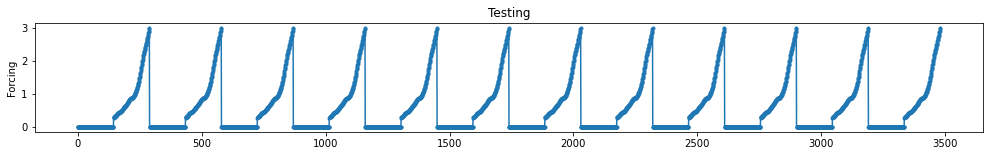

In [7]:
fig = plt.figure(figsize = (17,2))
plt.plot(y_test.values, '.-')
plt.ylabel("Forcing")
plt.title("Testing");

{'whiskers': [<matplotlib.lines.Line2D at 0x7ff4517d90f0>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff462a95710>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff4517d9710>],
 'medians': [<matplotlib.lines.Line2D at 0x7ff4510669b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ff45106f5f8>],
 'means': []}

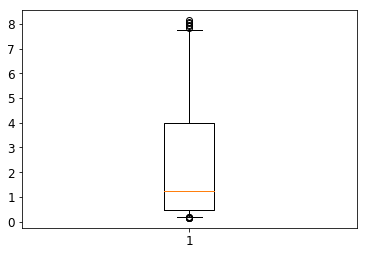

In [236]:
z = y_test.values[:231]
plt.boxplot(z, whis = [2.5, 97.5])

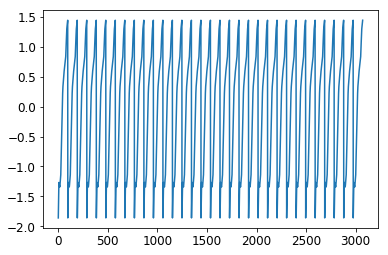

In [237]:
plt.plot(y)

### Cross-validation

Compute MSE for cross validation.

In [8]:
# variables = ["tas"]
# temporalRes = "ann"
# grid = (72, 144)
# scenarios = ["rcp85"]
# startDate, endDate = 1870, 2005
# forcing = "aerosols"

# modelsDataList, modelsInfoFrame = readFiles(variables, temporalRes, scenarios, startDate, endDate, norm = True)
# dict_models = generateData(modelsDataList, modelsInfoFrame, forcing, nbFoldsCV = 5)

lambdasCV = np.logspace(-2, 6, 50)
mse = np.zeros([len(lambdasCV), len(dict_models["trainData_listFolds"])])

for i in range(len(dict_models["trainData_listFolds"])):
#     print("---- Fold = " + str(i) + " ----")
    X_val = dict_models["trainData_listFolds"][i]
    y_val = dict_models["trainForcing_listFolds"][i]
    X_train_CV = pd.DataFrame()
    y_train_CV = pd.DataFrame()
    for j in range(len(dict_models["trainData_listFolds"])):
        if j != i:
            X_train_CV = pd.concat([X_train_CV, dict_models["trainData_listFolds"][j]], axis = 0)
            y_train_CV = pd.concat([y_train_CV, dict_models["trainForcing_listFolds"][j]], axis = 0)
  
    # Create a scaler object
    sc_X_train_CV = StandardScaler(with_mean=True, with_std=True)
    sc_X_val = StandardScaler(with_mean=True, with_std=True)
    sc_y_train_CV = StandardScaler(with_mean=True, with_std=True)
    sc_y_val = StandardScaler(with_mean=True, with_std=True)

    # Fit the scaler to the training data and transform
    X_train_CV_std = sc_X_train_CV.fit_transform(X_train_CV.values)
    X_val_std = sc_X_val.fit_transform(X_val.values)
    y_train_CV_std = sc_y_train_CV.fit_transform(y_train_CV.values)
    y_val_std = sc_y_val.fit_transform(y_val.values)
    
    X = X_train_CV_std
    y = y_train_CV_std
    X_val = X_val_std
    y_val_true = y_val_std
  
    for l in range(len(lambdasCV)):
        regr = linear_model.Ridge(alpha = X.shape[0] * lambdasCV[l] / 2)
        regr.fit(X, y)
        y_val_pred = regr.predict(X_val)
        mse[l][i] = np.mean((y_val_true - y_val_pred)**2)        

l = ["MSE - Fold " + str(i) for i in range(len(dict_models["trainData_listFolds"]))]
mse_df = pd.DataFrame(mse, index = lambdasCV, columns = l)
mse_df['TOTAL'] = np.mean(mse, axis = 1)
mse_df.index.name = 'Lambda'
mse_df.head()

#mse_df.to_csv("./../output/data/MSE_rcp85_norm_train30_cv5_lambda0_5_100.csv")

/home/eniko/anaconda3/envs/DASH/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=2.52292e-08): result may not be accurate.
  overwrite_a=False)
/home/eniko/anaconda3/envs/DASH/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=3.25429e-08): result may not be accurate.
  overwrite_a=False)
/home/eniko/anaconda3/envs/DASH/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=5.01846e-08): result may not be accurate.
  overwrite_a=False)
/home/eniko/anaconda3/envs/DASH/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=2.49662e-08): result may not be accurate.
  overwrite_a=False)
/home/eniko/anaconda3/envs/DASH/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=3.53446e-08): result may not be accurate.
 

MSE - Fold 0  MSE - Fold 1  MSE - Fold 2     TOTAL
Lambda                                                      
0.010000      0.303072      0.306725      0.326720  0.312172
0.014563      0.294355      0.294325      0.308574  0.299084
0.021210      0.286441      0.282877      0.293520  0.287613
0.030888      0.279040      0.272696      0.281189  0.277642
0.044984      0.272101      0.263665      0.271066  0.268944

#### Plot MSE

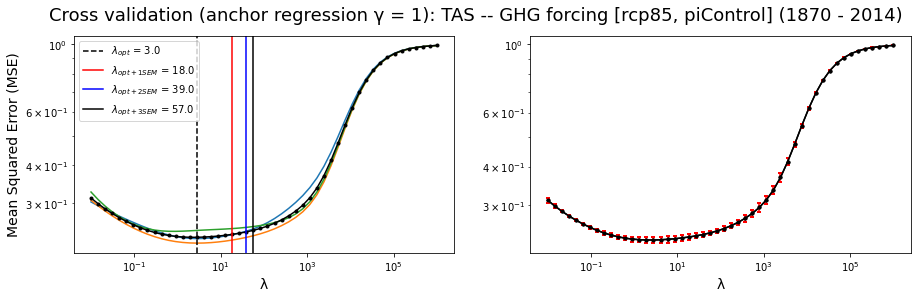

In [13]:
# mse_total = mse_df['TOTAL']

# nbStd = np.array([1, 2, 3])
# clr = ['r', 'b', 'k']

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))

# # Compute Standard error of the mean (SEM): σ_μ = σ / \sqrt{K}
# stdError = np.zeros(len(lambdasCV))
# for i in range(mse_df.shape[0]):
#     stdError[i] = stats.sem(mse_df.iloc[i, :-1], ddof = 0) 
    
# for i in range(mse_df.shape[1] - 1):
#     ax1.plot(lambdasCV, mse_df.iloc[:, i], label = "_nolegend_")

# ax1.plot(lambdasCV, mse_df.iloc[:, i+1], 'k.-')

# for j in range(len(nbStd)):
# # Choose the optimal lambda
#     lambdaOpt = mse_total[mse_total == np.max(mse_total[mse_total <= np.min(mse_total) + \
#                                                     nbStd[j] * stats.sem(mse_df.iloc[0,:-1], ddof = 0)])].index[0]
#     ax1.axvline(lambdaOpt, color = clr[j], label = "$\lambda_" + str(nbStd[j]) + "$ = " + str(np.round(lambdaOpt)))
    
# ax1.set_xscale('log')
# ax1.set_yscale('log')
# ax1.set_ylabel('Mean Squared Error (MSE)', fontsize = 14)
# ax1.set_xlabel('λ', fontsize = 14);
# ax1.legend(fontsize = 14);

# ax2.plot(lambdasCV, mse_df['TOTAL'], 'k.-')
# ax2.errorbar(lambdasCV, mse_df['TOTAL'], yerr = stdError, fmt = 'k.-', ecolor = 'b', capsize = 2, capthick = 2)  
# ax2.set_xscale('log')
# ax2.set_yscale('log')
# ax2.set_xlabel('λ', fontsize = 14);

target = forcing

mse_total = mse_df['TOTAL']

nbStd = np.array([1, 2, 3])
clr = ['r', 'b', 'k']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 4))
suptitle = "Cross validation (anchor regression γ = " + str(gamma) + "): " + variables[0].upper() + " -- " + target.upper() + " forcing [" + ', '.join(scenarios) + "] (" + \
            str(startDate) + " - " + str(endDate) + ") \n"
fig.suptitle(suptitle, fontsize = 18)

# Compute Standard error of the mean (SEM): σ_μ = σ / \sqrt{K}
stdError = np.zeros(len(lambdasCV))
for i in range(mse_df.shape[0]):
    stdError[i] = stats.sem(mse_df.iloc[i, :-1], ddof = 0) 
    
for i in range(mse_df.shape[1] - 1):
    ax1.plot(lambdasCV, mse_df.iloc[:, i], label = "_nolegend_")

ax1.plot(lambdasCV, mse_df.iloc[:, i+1], 'k.-')

lambdaOpt = mse_total[mse_total == np.min(mse_total)].index[0]
ax1.axvline(lambdaOpt, ls = '--', color = 'k', label = "$\lambda_{opt}$ = " + str(np.round(lambdaOpt)))
mse_total_sel = mse_total[lambdaOpt:]

for j in range(len(nbStd)):
# Choose the optimal lambda
    lambdaSel = mse_total_sel[mse_total_sel == np.max(mse_total_sel[mse_total_sel <= np.min(mse_total_sel) + \
                     nbStd[j] * stats.sem(mse_df.loc[lambdaOpt][:-1], ddof = 0)])].index[0]
    ax1.axvline(lambdaSel, color = clr[j], label = "$\lambda_{opt + " + str(nbStd[j]) + " SEM} $ = " + \
                str(np.round(lambdaSel)))
    
# lambdaSel = mse_total_sel[mse_total_sel == np.max(mse_total_sel[mse_total_sel <= \
#                                                                     1.1 * np.min(mse_total_sel)])].index[0]
# ax1.axvline(lambdaSel, color = 'b', label = "$\lambda_{opt} = $" + str(np.round(lambdaSel)))
    
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel('Mean Squared Error (MSE)', fontsize = 14)
ax1.set_xlabel('λ', fontsize = 14);
ax1.legend(fontsize = 10);

ax2.plot(lambdasCV, mse_df['TOTAL'], 'k.-')
ax2.errorbar(lambdasCV, mse_df['TOTAL'], yerr = stdError, fmt = 'k.-', ecolor = 'r', capsize = 2, capthick = 2)  
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('λ', fontsize = 14);

NameError: name 'plotBasemap_subplots' is not defined

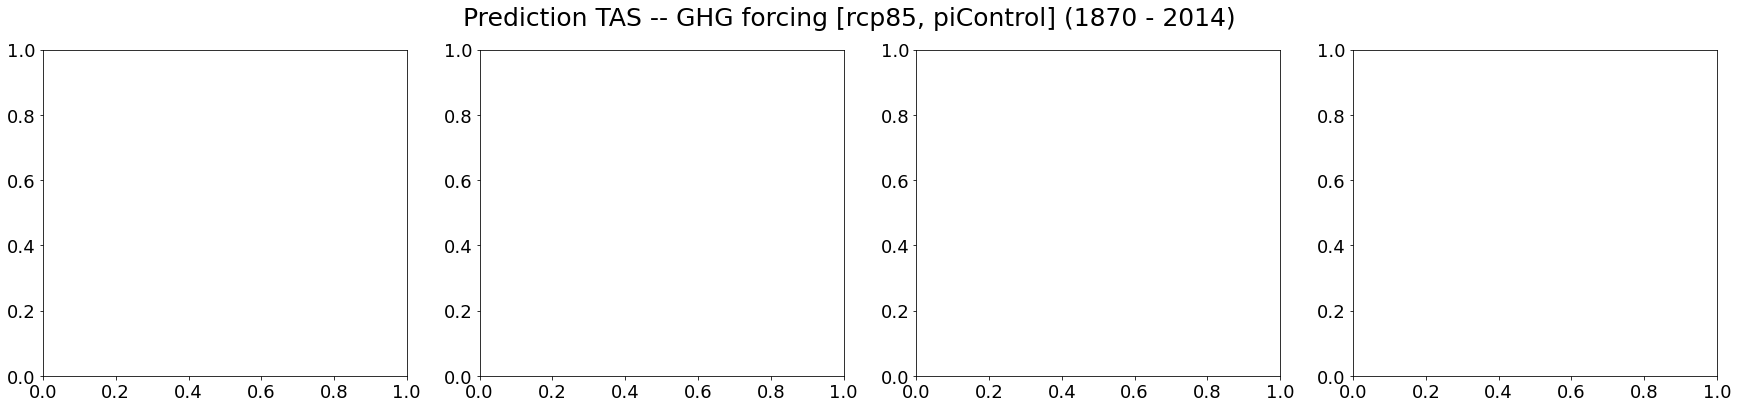

In [17]:
mpl.rcParams['xtick.labelsize'] = 18 
mpl.rcParams['ytick.labelsize'] = 18 
mpl.rcParams['font.size'] = 22
mpl.rcParams['axes.labelsize'] = 24
fs = 24

lambdaSeq = np.sort(np.array([39]))

fig = plt.figure(figsize = (25, 4 * len(lambdaSeq) ))

if len(lambdaSeq) == 1:
    axes = axes.reshape(1, -1)
    
for i in range(lambdaSeq.shape[0]):
    regr = linear_model.Ridge(X.shape[0] * lambdaSeq[i] / 2, solver = 'auto')
#    regr = linear_model.Ridge(lambdaSeq[i])
    regr.fit(X, y)
    coefStd = regr.coef_
    coefRaw = np.transpose(coefStd) / np.array(std_X_train).reshape(X_train.shape[1], 1)

#     regr = linear_model.ElasticNet(10, l1_ratio = 0.001)
#     regr.fit(X, y)
#     coefStd = regr.coef_.reshape(1, -1)
#     coefRaw = np.transpose(coefStd) / np.array(std_X_train).reshape(X_train.shape[1], 1)

    y_test_pred = regr.predict(Xt)
#     y_test_true = yt
#     y_test_true = (y_test_true - np.mean(y_test_true)) / np.std(y_test_true) * np.std(y_test.values) + np.mean(y_test.values)
#     y_test_pred = (y_test_pred - np.mean(y_test_pred)) / np.std(y_test_pred) * np.std(y_test.values) + np.mean(y_test.values)

    rmse = np.sqrt(np.mean((yt - y_test_pred)**2)) 
    r2 = r2_score(yt, y_test_pred)

    # Make the plots
    ax = fig.add_subplot(len(lambdaSeq), 4, i * 4 + 1, projection = ccrs.Robinson())
    title = "Raw coefficients: $\lambda$ = " + str(int(np.round(lambdaSeq[i])))
    plotMapCartopy_subplots(ax, coefRaw.reshape(grid), cLim = None, title_subplot = title, fontSize = fs)
        
    ax = fig.add_subplot(len(lambdaSeq), 4, i * 4 + 2, projection = ccrs.Robinson())
    title = "Standardized coefficients: $\lambda$ = " + str(int(np.round(lambdaSeq[i])))
    plotMapCartopy_subplots(ax, coefRaw.reshape(grid), cLim = None, title_subplot = title, fontSize = fs)

    ax = fig.add_subplot(len(lambdaSeq), 4, i * 4 + 3)
    plt.plot(yt, y_test_pred)
#     plt.plot(yt[: 135], y_test_pred[: 135], 'r.')
#     plt.plot(yt[135:231], y_test_pred[135:231], 'b.')
#     plt.plot(yt[231:365], y_test_pred[231:365], 'r.')
#     plt.plot(yt[365:], y_test_pred[365:], 'b.')
    plt.xlabel("True forcing")
    plt.ylabel("Predicted forcing")

    if forcing == "anthro": x = np.linspace(-1, 2.5, 100)
    elif forcing == "solar": x = np.linspace(-0.05, 0.20, 100)
    elif forcing == "volcanic": x = np.linspace(-1.5, 0.25, 100)
    elif forcing == "natural": x = np.linspace(-1.5, 0.50, 100)
    elif forcing == "aerosols": x = np.linspace(-2, 1.5, 100)

    plt.plot(x, x, 'k', linestyle = 'solid')
    plt.title("RMSE = " + str(np.round(rmse, 4)) + " --- R2 = " + str(np.round(r2, 4)))
    
    ax = fig.add_subplot(len(lambdaSeq), 4, i * 4 + 4)
    plt.plot(yt, label = "True forcing")
    plt.plot(y_test_pred, label = "Predicted forcing")
#     plt.plot(np.array(range(135)), y_test_pred[:135], 'r.', label = "Predicted 1870-2005")
#     plt.plot(np.array(range(135, 231)), y_test_pred[135:231], 'b.', label = "Predicted 2006-2100")
#     plt.plot(np.array(range(231, 365)), y_test_pred[231:365], 'r.')
#     plt.plot(np.array(range(365, 462)), y_test_pred[365:], 'b.')
    plt.xlabel("Time/Model")
    plt.ylabel("Forcing")
    plt.legend(fontsize = 18);

plt.tight_layout(rect = [0, 0, 1, 0.93])
#fig.savefig("./../output/figures/figsPres/rcp85_control_anthro_2100.png")

In [25]:
X_test.shape

(462, 10368)

In [626]:
coefRaw_2005 = coefRaw
coefStd_2005 = coefStd
r2_2005 = r2

In [607]:
coefRaw_2005_2 = coefRaw
coefStd_2005_2 = coefStd
r2_2005_2 = r2

In [609]:
coefRaw_2005_3 = coefRaw
coefStd_2005_3 = coefStd
r2_2005_3 = r2

Text(0, 0.5, 'Coef anthro (2005-2100)')

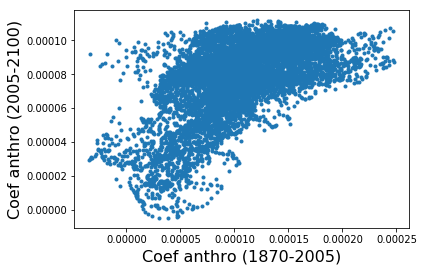

In [643]:
mpl.rcParams['xtick.labelsize'] = 10 
mpl.rcParams['ytick.labelsize'] = 10 
mpl.rcParams['axes.labelsize'] = 16
plt.plot(np.transpose(coefStd_2005_3), np.transpose(coefStd), '.')
# plt.plot(coefRaw_2005, coefRaw, '.')
plt.xlabel("Coef anthro (1870-2005)")
plt.ylabel("Coef anthro (2005-2100)")

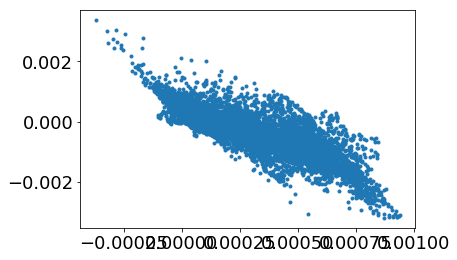

In [501]:
plt.plot(coefRaw, coefRaw_aer, '.')

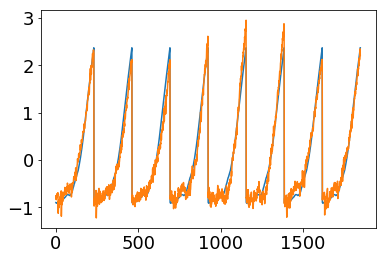

In [320]:
residuals = (yt - y_test_pred).reshape(-1)
plt.plot(yt)
plt.plot(y_test_pred)
# plt.plot(residuals)

In [422]:
temp_nc = netCDF4.Dataset("./../data/mount/_DATA/CMIP5/2D/tas/tas_ann_MRI-CGCM3_rcp85_r1i1p1_g025.nc")
temp_ncdata = np.array(temp_nc.variables["tas"])
temp_ncdata = temp_ncdata.reshape(temp_ncdata.shape[0], temp_ncdata.shape[1]*temp_ncdata.shape[2])

dates = pd.to_datetime(netCDF4.num2date(temp_nc.variables['year'][:], temp_nc.variables['year'].units)).year
temp_ncdata_df = pd.DataFrame(temp_ncdata, index = dates)
temp_ncdata_df_selDates = temp_ncdata_df

meanmap = np.mean(temp_ncdata_df.loc['1870':'1920'], axis = 0)
temp_ncdata_df_selDates = temp_ncdata_df_selDates - meanmap

# temp_nc = netCDF4.Dataset("./../data/mount/_DATA/CMIP5/2D/tas/tas_ann_MRI-CGCM3_historicalNat_r1i1p1_g025.nc")
# temp_ncdata = np.array(temp_nc.variables["tas"])
# temp_ncdata = temp_ncdata.reshape(temp_ncdata.shape[0], temp_ncdata.shape[1]*temp_ncdata.shape[2])

# dates = pd.to_datetime(netCDF4.num2date(temp_nc.variables['year'][:], temp_nc.variables['year'].units)).year
# temp_ncdata_df = pd.DataFrame(temp_ncdata, index = dates)
# temp_ncdata_df_selDates2 = temp_ncdata_df

# meanmap = np.mean(temp_ncdata_df.loc['1870':'1920'], axis = 0)
# temp_ncdata_df_selDates2 = temp_ncdata_df_selDates2 - meanmap


In [423]:
# histGHG = np.matmul(temp_ncdata_df_selDates,np.transpose(coefStd))
# histNat = np.matmul(temp_ncdata_df_selDates2,np.transpose(coefStd))

# histGHG = np.matmul(temp_ncdata,coefRaw)
# histNat = np.matmul(temp_ncdata2,coefRaw)

rcp85 = np.matmul(temp_ncdata_df_selDates,np.transpose(coefStd))


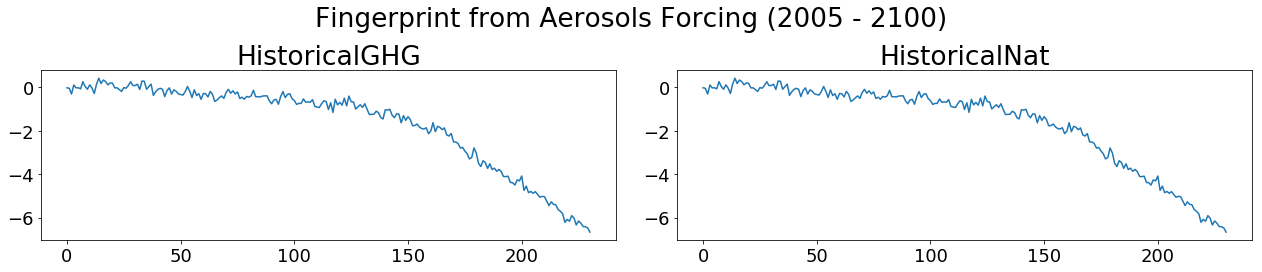

In [426]:
fig, axes = plt.subplots(1,2, figsize = (18,4))
fig.subplots_adjust(top = 0.9)

fig.suptitle("Fingerprint from Aerosols Forcing (2005 - 2100)")

fig.sca(axes[0])
plt.plot(rcp85)
plt.title("HistoricalGHG")

fig.sca(axes[1])
plt.plot(rcp85)
plt.title("HistoricalNat")

plt.tight_layout(rect = [0, 0.0, 1, 0.93]);

### Anchor regression

Building the anchor $A \in \mathbb{R}^{n,q}$ with $q = $ number of anchors

#### Data standardization

In [15]:
X_train = pd.DataFrame()
y_train = pd.DataFrame()
X_test = dict_models["X_test"]
y_test = dict_models["y_test"]

for i in range(len(dict_models["trainData_listFolds"])):
    X_train = pd.concat([X_train, dict_models["trainData_listFolds"][i]], axis = 0)
    y_train = pd.concat([y_train, dict_models["trainForcing_listFolds"][i]], axis = 0)

In [16]:
stdVal = True

# Create a scaler object
sc_X = StandardScaler(with_mean=True, with_std=True)
sc_y = StandardScaler(with_mean=True, with_std=stdVal)
sc_X_test = StandardScaler(with_mean=True, with_std=True)
sc_y_test = StandardScaler(with_mean=True, with_std=stdVal)

# Fit the scaler to the data and transform
X_train_std = sc_X.fit_transform(X_train.values)
y_train_std = sc_y.fit_transform(y_train.values)
X_test_std = sc_X_test.fit_transform(X_test.values)
y_test_std = sc_y_test.fit_transform(y_test.values)

X = X_train_std
y = y_train_std
Xt = X_test_std
yt = y_test_std

# rollingWindow = 10
# X = X_train_std
# #y = y_train.values
# y = y_train.rolling(rollingWindow).mean().values
# y[:rollingWindow] = y_train[:rollingWindow]
# Xt = X_test_std
# #y_test_true = y_test.values
# yt = y_test.rolling(rollingWindow).mean().values
# yt[:rollingWindow] = y_test[:rollingWindow]

std_X_train = X_train.std(axis=0) # can also get it back from the scaler object

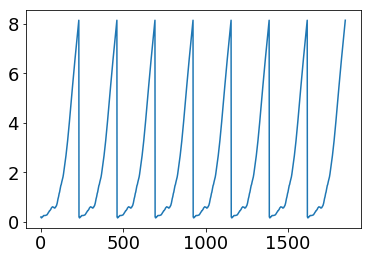

In [249]:
plt.plot(y_test.values)
# plt.plot(y_test.rolling(rollingWindow, center = False).mean().values)
# plt.plot(y_test.rolling(rollingWindow, center = True).mean().values)

#### Standardize all the forcings for the training data

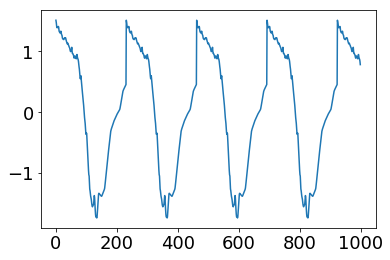

In [250]:
y_ant = np.tile(readForcing(scenarios[0], "anthro", startDate, endDate), len(dict_models["trainFiles"])).reshape(-1,1)
y_sol = np.tile(readForcing(scenarios[0], "solar", startDate, endDate), len(dict_models["trainFiles"])).reshape(-1,1)
y_vol = np.tile(readForcing(scenarios[0], "volcanic", startDate, endDate), len(dict_models["trainFiles"])).reshape(-1,1)
y_aer = np.tile(readForcing(scenarios[0], "aerosols", startDate, endDate), len(dict_models["trainFiles"])).reshape(-1,1)
y_GHG = np.tile(readForcing(scenarios[0], "GHG", startDate, endDate), len(dict_models["trainFiles"])).reshape(-1,1)

sc_y_ant = StandardScaler(with_mean=True, with_std=stdVal)
y_ant_std = sc_y_ant.fit_transform(y_ant)

sc_y_sol = StandardScaler(with_mean=True, with_std=stdVal)
y_sol_std = sc_y_sol.fit_transform(y_sol)

sc_y_vol = StandardScaler(with_mean=True, with_std=stdVal)
y_vol_std = sc_y_vol.fit_transform(y_vol)

sc_y_aer = StandardScaler(with_mean=True, with_std=stdVal)
y_aer_std = sc_y_aer.fit_transform(y_aer)

sc_y_GHG = StandardScaler(with_mean=True, with_std=stdVal)
y_GHG_std = sc_y_GHG.fit_transform(y_GHG)

y_nat = y_sol + y_vol
sc_y_nat = StandardScaler(with_mean=True, with_std=stdVal)
y_nat_std = sc_y_nat.fit_transform(y_nat)
    
# how to standardize the forcings?
z = y_sol_std + y_vol_std
# plt.plot(z[:1000]);
# plt.plot(y_nat_std[:1000]);
plt.plot(y_aer_std[:1000])

#### Choose the forcing(s) used as anchor(s)

In [251]:
constraintForcing = "volcanic"

A = np.zeros( (X_train.shape[0], 1) )

if constraintForcing == "anthro":
    A[:,0] = y_ant_std.reshape(-1) # np.tile( np.array(radForcing_df_rcp85_solar).reshape(-1), nbTrain )
elif constraintForcing == "solar":
    A[:,0] = y_sol_std.reshape(-1) # np.tile( np.array(radForcing_df_rcp85_solar).reshape(-1), nbTrain )
elif constraintForcing == "volcanic":
    A[:,0] = y_vol_std.reshape(-1) # np.tile( np.array(radForcing_df_rcp85_solar).reshape(-1), nbTrain )
elif constraintForcing == "natural":
    A[:,0] = y_nat_std.reshape(-1) # np.tile( np.array(radForcing_df_rcp85_solar).reshape(-1), nbTrain )
elif constraintForcing == "aerosols":
    A[:,0] = y_aer_std.reshape(-1) # np.tile( np.array(radForcing_df_rcp85_solar).reshape(-1), nbTrain )
elif constraintForcing == "GHG":
    A[:,0] = y_GHG_std.reshape(-1) # np.tile( np.array(radForcing_df_rcp85_solar).reshape(-1), nbTrain )

# #A[:,0] = np.tile( np.array(radForcing_df_rcp85_solar).reshape(-1), nbTrain )
# #A[:,1] = np.tile( np.array(radForcing_df_rcp85_volcanic).reshape(-1), nbTrain )
A = np.mat( A ) # important for matrix multiplication (* doesn't act the same on matrices or arrays)
PA = A * np.linalg.inv( np.transpose(A) * A ) * np.transpose(A)

In [252]:
A = np.zeros( (X_train.shape[0], 2) )
A[:,0] = y_vol_std.reshape(-1)
A[:,1] = y_vol_std.reshape(-1)**2
A = np.mat(A)

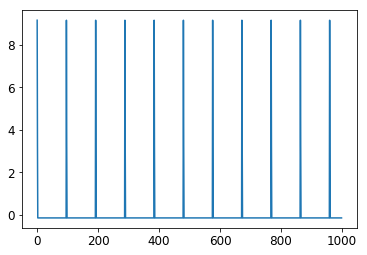

In [14]:
plt.plot(A[:1000,0])
#plt.plot(A[:1000,1])

In [16]:
AtA = A.T * A
AtA

matrix([[6237.]])

In [56]:
AtA_inv = np.linalg.inv(A.T * A)
AtA_inv

matrix([[1.94265921e-04, 3.79871219e-05],
        [3.79871219e-05, 1.18168234e-05]])

In [58]:
AtA * AtA_inv

matrix([[1., 0.],
        [0., 1.]])

In [59]:
AtA_inv * AtA

matrix([[ 1.00000000e+00,  1.77635684e-15],
        [-1.11022302e-16,  1.00000000e+00]])

In [61]:
AtA[0,0]

13859.999999999995

In [62]:
AtA[0,0].T

13859.999999999995

#### Standardize all the forcings in the test data

In [253]:
# Needed when plotting the residuals vs the anchor

y_ant_test = np.tile(readForcing(scenarios[0], "anthro", startDate, endDate), len(dict_models["testFiles"])).reshape(-1,1)
y_sol_test = np.tile(readForcing(scenarios[0], "solar", startDate, endDate), len(dict_models["testFiles"])).reshape(-1,1)
y_vol_test = np.tile(readForcing(scenarios[0], "volcanic", startDate, endDate), len(dict_models["testFiles"])).reshape(-1,1)
y_aer_test = np.tile(readForcing(scenarios[0], "aerosols", startDate, endDate), len(dict_models["testFiles"])).reshape(-1,1)
y_GHG_test = np.tile(readForcing(scenarios[0], "GHG", startDate, endDate), len(dict_models["testFiles"])).reshape(-1,1)

sc_y_ant_test = StandardScaler(with_mean=True, with_std=stdVal)
y_ant_test_std = sc_y_ant_test.fit_transform(y_ant_test)

sc_y_sol_test = StandardScaler(with_mean=True, with_std=stdVal)
y_sol_test_std = sc_y_sol_test.fit_transform(y_sol_test)

sc_y_vol_test = StandardScaler(with_mean=True, with_std=stdVal)
y_vol_test_std = sc_y_vol_test.fit_transform(y_vol_test)

sc_y_aer_test = StandardScaler(with_mean=True, with_std=stdVal)
y_aer_test_std = sc_y_aer_test.fit_transform(y_aer_test)

sc_y_GHG_test = StandardScaler(with_mean=True, with_std=stdVal)
y_GHG_test_std = sc_y_GHG_test.fit_transform(y_GHG_test)

y_nat_test = y_sol_test + y_vol_test
sc_y_nat_test = StandardScaler(with_mean=True, with_std=stdVal)
y_nat_test_std = sc_y_nat_test.fit_transform(y_nat_test)

if constraintForcing == "anthro":
    w_test = y_ant_test_std
elif constraintForcing == "solar":
    w_test = y_sol_test_std
elif constraintForcing == "volcanic":
    w_test = y_vol_test_std
elif constraintForcing == "natural":
    w_test = y_nat_test_std
elif constraintForcing == "aerosols":
    w_test = y_aer_test_std
elif constraintForcing == "GHG":
    w_test = y_GHG_test_std

### Anchor regression - CV

In [17]:
for i in range(len(dict_models["trainData_listFolds"])):
#     print("---- Fold = " + str(i) + " ----")
    X_val = dict_models["trainData_listFolds"][i]
    y_val = dict_models["trainForcing_listFolds"][i]
    X_train_CV = pd.DataFrame()
    y_train_CV = pd.DataFrame()
    for j in range(len(dict_models["trainData_listFolds"])):
        if j != i:
            X_train_CV = pd.concat([X_train_CV, dict_models["trainData_listFolds"][j]], axis = 0)
            y_train_CV = pd.concat([y_train_CV, dict_models["trainForcing_listFolds"][j]], axis = 0)

In [18]:
variables = ["tas"]
temporalRes = "ann"
grid = (72, 144)
scenarios = ["rcp85"]
startDate, endDate = 1870, 2100
forcing = "aerosols"

modelsDataList, modelsInfoFrame = readFiles(variables, temporalRes, scenarios, startDate, endDate, norm = True)

dict_models = generateData(modelsDataList, modelsInfoFrame, forcing, nbFoldsCV = 5)

lambdasCV = np.logspace(-2, 6, 10)
mse = np.zeros([len(lambdasCV), len(dict_models["trainData_listFolds"])])

gamma = 10000
constraintForcing = "GHG"

for i in range(len(dict_models["trainData_listFolds"])):
#     print("---- Fold = " + str(i) + " ----")
    X_val = dict_models["trainData_listFolds"][i]
    y_val = dict_models["trainForcing_listFolds"][i]
    X_train_CV = pd.DataFrame()
    y_train_CV = pd.DataFrame()
    for j in range(len(dict_models["trainData_listFolds"])):
        if j != i:
            X_train_CV = pd.concat([X_train_CV, dict_models["trainData_listFolds"][j]], axis = 0)
            y_train_CV = pd.concat([y_train_CV, dict_models["trainForcing_listFolds"][j]], axis = 0)
  
    y_vol = np.tile(readForcing(scenarios[0], "volcanic", startDate, endDate), 
                    int(X_train_CV.shape[0] / (endDate - startDate + 1))).reshape(-1,1)
    sc_y_vol = StandardScaler(with_mean = True, with_std = True)
    y_vol_std = sc_y_vol.fit_transform(y_vol)

    y_aer = np.tile(readForcing(scenarios[0], "aerosols", startDate, endDate), 
                    int(X_train_CV.shape[0] / (endDate - startDate + 1))).reshape(-1,1)
    sc_y_aer = StandardScaler(with_mean = True, with_std = True)
    y_aer_std = sc_y_aer.fit_transform(y_aer)

    y_GHG = np.tile(readForcing(scenarios[0], "GHG", startDate, endDate), 
                    int(X_train_CV.shape[0] / (endDate - startDate + 1))).reshape(-1,1)
    sc_y_GHG = StandardScaler(with_mean = True, with_std = True)
    y_GHG_std = sc_y_GHG.fit_transform(y_GHG)

    A = np.zeros( (X_train_CV.shape[0], 1) )

    if constraintForcing == "anthro":
        A[:,0] = y_ant_std.reshape(-1) 
    elif constraintForcing == "solar":
        A[:,0] = y_sol_std.reshape(-1) 
    elif constraintForcing == "volcanic":
        A[:,0] = y_vol_std.reshape(-1) 
    elif constraintForcing == "natural":
        A[:,0] = y_nat_std.reshape(-1) 
    elif constraintForcing == "aerosols":
        A[:,0] = y_aer_std.reshape(-1) 
    elif constraintForcing == "GHG":
        A[:,0] = y_GHG_std.reshape(-1) 

    # #A[:,0] = np.tile( np.array(radForcing_df_rcp85_solar).reshape(-1), nbTrain )
    # #A[:,1] = np.tile( np.array(radForcing_df_rcp85_volcanic).reshape(-1), nbTrain )
    A = np.mat( A ) # important for matrix multiplication (* doesn't act the same on matrices or arrays)
    PA = A * np.linalg.inv( np.transpose(A) * A ) * np.transpose(A)

    # Create a scaler object
    sc_X_train_CV = StandardScaler(with_mean=True, with_std=True)
    sc_X_val = StandardScaler(with_mean=True, with_std=True)
    sc_y_train_CV = StandardScaler(with_mean=True, with_std=True)
    sc_y_val = StandardScaler(with_mean=True, with_std=True)

    # Fit the scaler to the training data and transform
    X_train_CV_std = sc_X_train_CV.fit_transform(X_train_CV.values)
    X_val_std = sc_X_val.fit_transform(X_val.values)
    y_train_CV_std = sc_y_train_CV.fit_transform(y_train_CV.values)
    y_val_std = sc_y_val.fit_transform(y_val.values)
    
    X = X_train_CV_std
    y = y_train_CV_std
    X_val = X_val_std
    y_val_true = y_val_std
  
    N, p = X.shape
    X_PA = ( np.mat(np.identity(N)) - PA ) * np.mat( X ) + np.sqrt( gamma ) * PA * np.mat( X )
    y_PA = ( np.mat(np.identity(N)) - PA ) * np.mat( y ) + np.sqrt( gamma ) * PA * np.mat( y )
        
    PA_C = np.identity(N) - PA
        
    for l in range(len(lambdasCV)):
        regr = linear_model.Ridge(alpha = X.shape[0] * lambdasCV[l] / 2)
        regr.fit(X_PA, y_PA)
        y_val_pred = regr.predict(X_val)
        
#         D_lambda = gamma * np.mat(X.T) * PA * np.mat(X) + np.mat(X.T) * np.mat(PA_C) * np.mat(X) + \
#                             N * lambdasCV[l] / 2 * np.identity(p)
#         d = gamma * np.mat(X.T) * PA * np.mat(y) + np.mat(X.T) * PA_C * np.mat(y) 
#         coefStd = np.linalg.inv(D_lambda) * d
#         y_val_pred = np.array(np.matmul(X_val, coefStd))

        mse[l][i] = np.mean((y_val_true - y_val_pred)**2)        

l = ["MSE - Fold " + str(i) for i in range(len(dict_models["trainData_listFolds"]))]
mse_df = pd.DataFrame(mse, index = lambdasCV, columns = l)
mse_df['MSE - TOTAL'] = np.mean(mse, axis = 1)
mse_df.index.name = 'Lambda'
mse_df.head()

#mse_df.to_csv("./../output/data/MSE_rcp85_norm_train30_cv5_lambda0_5_100.csv")

Fold 0 : [CMC, Can, Had, MPI]
Fold 1 : [CSI, GIS, IPS]
Fold 2 : [CNR, FGO, MRI]
Fold 3 : [ACC, BNU, CES]
Fold 4 : [CCS, GFD, Nor]
Testing : [EC-, bcc, inm, MIR, FIO]


MSE - Fold 0  MSE - Fold 1  MSE - Fold 2  MSE - Fold 3  \
Lambda                                                              
0.010000       0.710647      0.749801      0.799108      0.561787   
0.077426       0.659426      0.705910      0.739887      0.468765   
0.599484       0.667798      0.715113      0.831378      0.496269   
4.641589       0.704432      0.704291      0.936731      0.625887   
35.938137      0.815503      0.784846      0.966411      0.794101   

           MSE - Fold 4  MSE - TOTAL  
Lambda                                
0.010000       0.706108     0.705490  
0.077426       0.617350     0.638268  
0.599484       0.645515     0.671214  
4.641589       0.793367     0.752942  
35.938137      0.889291     0.850030

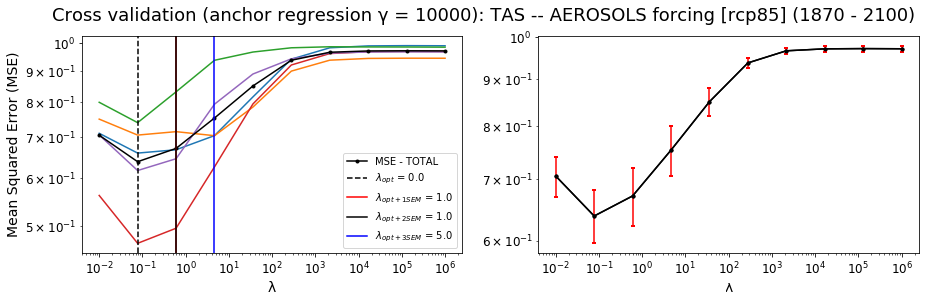

In [19]:
mse_total = mse_df['MSE - TOTAL']

nbStd = np.array([1, 2, 3])
clr = ['r', 'k', 'b']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 4))
suptitle = "Cross validation (anchor regression γ = " + str(gamma) + "): " + variables[0].upper() + " -- " + forcing.upper() + " forcing [" + ', '.join(scenarios) + "] (" + \
            str(startDate) + " - " + str(endDate) + ") \n"
fig.suptitle(suptitle, fontsize = 18)

# Compute Standard error of the mean (SEM): σ_μ = σ / \sqrt{K}
stdError = np.zeros(len(lambdasCV))
for i in range(mse_df.shape[0]):
    stdError[i] = stats.sem(mse_df.iloc[i, :-1], ddof = 0) 
    
for i in range(mse_df.shape[1] - 1):
    ax1.plot(lambdasCV, mse_df.iloc[:, i], label = "_nolegend_")

ax1.plot(lambdasCV, mse_df.iloc[:, i+1], 'k.-')

lambdaOpt = mse_total[mse_total == np.min(mse_total)].index[0]
ax1.axvline(lambdaOpt, ls = '--', color = 'k', label = "$\lambda_{opt}$ = " + str(np.round(lambdaOpt)))
mse_total_sel = mse_total[lambdaOpt:]

for j in range(len(nbStd)):
# Choose the optimal lambda
    lambdaSel = mse_total_sel[mse_total_sel == np.max(mse_total_sel[mse_total_sel <= np.min(mse_total_sel) + \
                     nbStd[j] * stats.sem(mse_df.loc[lambdaOpt][:-1], ddof = 0)])].index[0]
    ax1.axvline(lambdaSel, color = clr[j], label = "$\lambda_{opt + " + str(nbStd[j]) + " SEM} $ = " + \
                str(np.round(lambdaSel)))
    
# lambdaSel = mse_total_sel[mse_total_sel == np.max(mse_total_sel[mse_total_sel <= \
#                                                                     1.1 * np.min(mse_total_sel)])].index[0]
# ax1.axvline(lambdaSel, color = 'b', label = "$\lambda_{opt} = $" + str(np.round(lambdaSel)))
    
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel('Mean Squared Error (MSE)', fontsize = 14)
ax1.set_xlabel('λ', fontsize = 14);
ax1.legend(fontsize = 10);

ax2.plot(lambdasCV, mse_df['MSE - TOTAL'], 'k.-')
ax2.errorbar(lambdasCV, mse_df['MSE - TOTAL'], yerr = stdError, fmt = 'k.-', ecolor = 'r', capsize = 2, capthick = 2)  
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('λ', fontsize = 14);

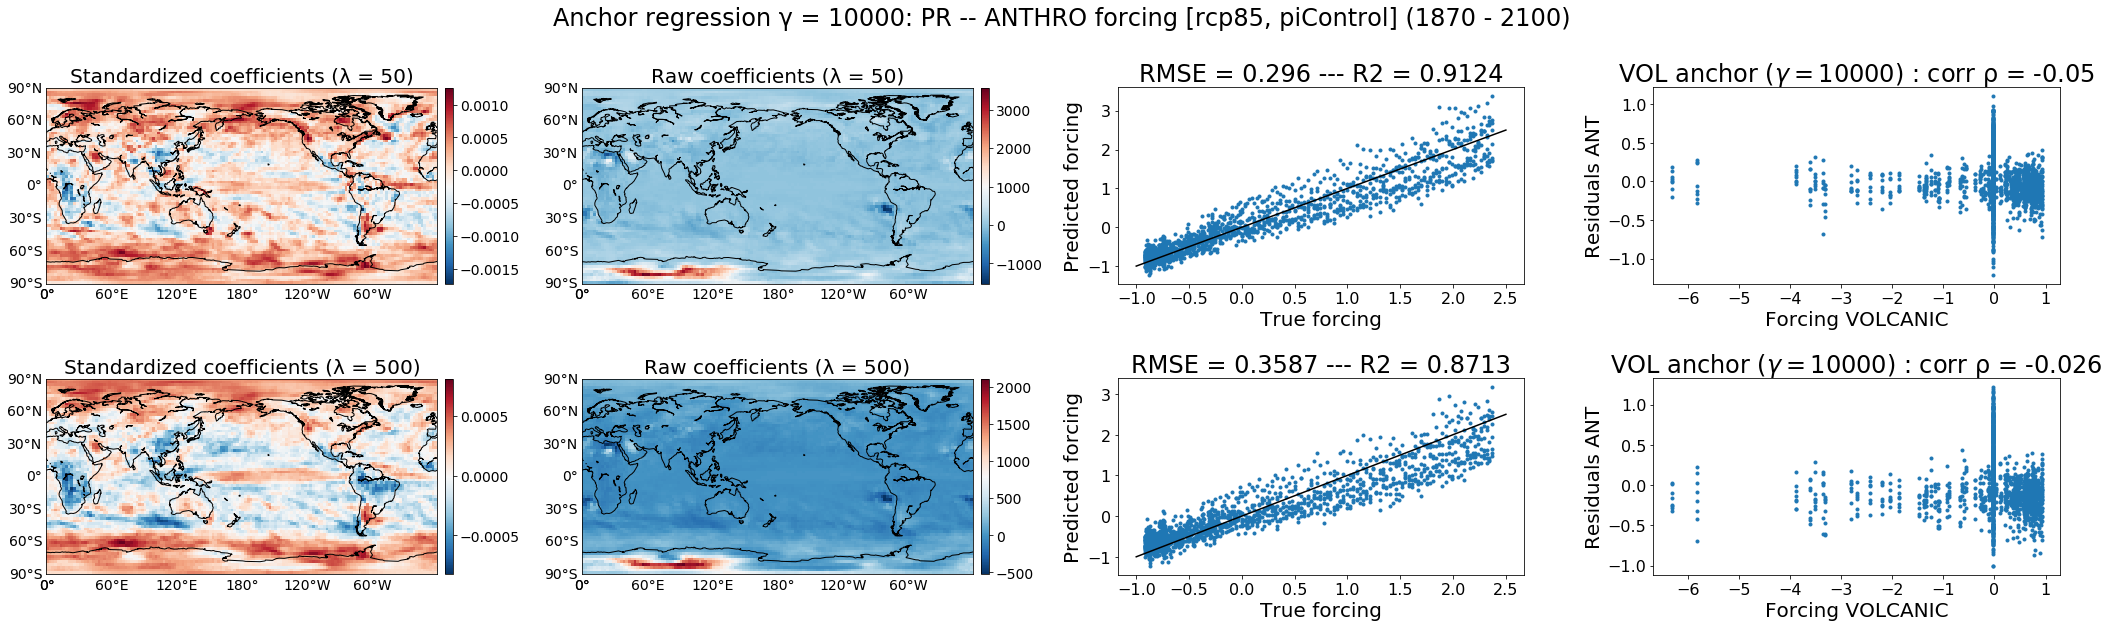

In [53]:
mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['font.size'] = 20
mpl.rcParams['axes.labelsize'] = 20
fs = 20

gamma = 10000
lambdaSeq = [50, 500]

fig, axes = plt.subplots(len(lambdaSeq), 4, figsize = (30, 4.5 * len(lambdaSeq)))
suptitle = "Anchor regression γ = " + str(gamma) + ": " + variables[0].upper() + " -- " + forcing.upper() + \
            " forcing [" + ', '.join(scenarios) + "] (" + str(startDate) + " - " + str(endDate) + ") \n"
fig.suptitle(suptitle, fontsize = 24)

N, p = X.shape
# X_PA = ( np.mat(np.identity(N)) - PA ) * np.mat( X ) + np.sqrt( gamma ) * PA * np.mat( X )
# y_PA = ( np.mat(np.identity(N)) - PA ) * np.mat( y ) + np.sqrt( gamma ) * PA * np.mat( y )

# regr = linear_model.Ridge(alpha = X.shape[0] * lambdaSeq[0] / 2)
# regr.fit(X_PA, y_PA)

# coefStd = regr.coef_

PA_C = np.identity(N) - PA
D_lambda = gamma * np.mat(X.T) * PA * np.mat(X) + np.mat(X.T) * np.mat(PA_C) * np.mat(X) + \
                            N * lambdaSeq[0] / 2 * np.identity(p)
d = gamma * np.mat(X.T) * PA * np.mat(y) + np.mat(X.T) * PA_C * np.mat(y) 
coefStd = np.linalg.inv(D_lambda) * d
coefStd = coefStd.T
y_test_pred = np.array(np.matmul(Xt, coefStd.T))
coefRaw = coefStd.T / np.array(std_X_train).reshape(X_train.shape[1], 1)   

fig.sca(axes[0,0])
plotBasemap_subplots(coefStd.reshape(grid), cLim = None, \
                     title_subplot = "Standardized coefficients (λ = " + str(lambdaSeq[0]) + ")", fontSize = fs);

fig.sca(axes[0,1])
plotBasemap_subplots(coefRaw.reshape(grid), cLim = None, \
                     title_subplot = "Raw coefficients (λ = " + str(lambdaSeq[0]) + ")", fontSize = fs);

# y_test_pred = regr.predict(Xt)
#y_test_pred = np.matmul(Xt, coefRaw)

# y_test_true = (yt - np.mean(yt)) / np.std(yt) * np.std(y_test.values) + np.mean(y_test.values)
# y_test_pred = (y_test_pred - np.mean(y_test_pred)) / np.std(y_test_pred) * np.std(y_test.values) + np.mean(y_test.values)

y_test_true = yt

fig.sca(axes[0,2])
plt.plot(y_test_true, y_test_pred, '.')
plt.xlabel("True forcing")
plt.ylabel("Predicted forcing")

if forcing == "anthro": x = np.linspace(-1, 2.5, 100)
elif forcing == "solar": x = np.linspace(0, 0.2, 100)
elif forcing == "volcanic": x = np.linspace(-1.5, 0.25, 100)
elif forcing == "natural": x = np.linspace(-1.5, 0.50, 100)
elif forcing == "all": x = np.linspace(-1.5, 2.5, 100)

plt.plot(x, x, 'k', linestyle = 'solid')

rmse = np.sqrt(np.mean((y_test_true - y_test_pred)**2)) 
r2 = r2_score(y_test_true, y_test_pred)
plt.title("RMSE = " + str(np.round(rmse, 4)) + " --- R2 = " + str(np.round(r2, 4)))

residuals = (y_test_true - y_test_pred).reshape(-1)

fig.sca(axes[0,3])
plt.plot(w_test, residuals, '.')
plt.xlabel("Forcing " + constraintForcing.upper())
plt.ylabel("Residuals " + forcing[:3].upper())
plt.title(constraintForcing[:3].upper() + " anchor ($\gamma = " + str(gamma) + "$) : corr ρ = " + \
             str(np.round(np.corrcoef(np.transpose(w_test), np.transpose(residuals))[0,1], 3)));

#--------------------------------
# regr = linear_model.Ridge(alpha = X.shape[0] * lambdaSeq[1] / 2)
# regr.fit(X_PA, y_PA)

# coefStd = regr.coef_
# coefRaw = np.transpose(coefStd) / np.array(std_X_train).reshape(X_train.shape[1], 1)   

D_lambda = gamma * np.mat(X.T) * PA * np.mat(X) + np.mat(X.T) * np.mat(PA_C) * np.mat(X) + \
                            N * lambdaSeq[1] / 2 * np.identity(p)
d = gamma * np.mat(X.T) * PA * np.mat(y) + np.mat(X.T) * PA_C * np.mat(y) 
coefStd = np.linalg.inv(D_lambda) * d
coefStd = coefStd.T
y_test_pred = np.array(np.matmul(Xt, coefStd.T))
coefRaw = coefStd.T / np.array(std_X_train).reshape(X_train.shape[1], 1) 

fig.sca(axes[1,0])
plotBasemap_subplots(coefStd.reshape(grid), cLim = None, \
                     title_subplot = "Standardized coefficients (λ = " + str(lambdaSeq[1]) + ")", fontSize = fs);

fig.sca(axes[1,1])
plotBasemap_subplots(coefRaw.reshape(grid), cLim = None, \
                     title_subplot = "Raw coefficients (λ = " + str(lambdaSeq[1]) + ")", fontSize = fs);

# y_test_pred = regr.predict(Xt)
#y_test_pred = np.matmul(Xt, coefRaw)

# y_test_true = (yt - np.mean(yt)) / np.std(yt) * np.std(y_test.values) + np.mean(y_test.values)
# y_test_pred = (y_test_pred - np.mean(y_test_pred)) / np.std(y_test_pred) * np.std(y_test.values) + np.mean(y_test.values)

y_test_true = yt

fig.sca(axes[1,2])
plt.plot(y_test_true, y_test_pred, '.')
plt.xlabel("True forcing")
plt.ylabel("Predicted forcing")

if forcing == "anthro": x = np.linspace(-1, 2.5, 100)
elif forcing == "solar": x = np.linspace(0, 0.2, 100)
elif forcing == "volcanic": x = np.linspace(-1.5, 0.25, 100)
elif forcing == "natural": x = np.linspace(-1.5, 0.50, 100)
elif forcing == "all": x = np.linspace(-1.5, 2.5, 100)

plt.plot(x, x, 'k', linestyle = 'solid')

rmse = np.sqrt(np.mean((y_test_true - y_test_pred)**2)) 
r2 = r2_score(y_test_true, y_test_pred)
plt.title("RMSE = " + str(np.round(rmse, 4)) + " --- R2 = " + str(np.round(r2, 4)))

residuals = (y_test_true - y_test_pred).reshape(-1)

fig.sca(axes[1,3])
plt.plot(w_test, residuals, '.')
plt.xlabel("Forcing " + constraintForcing.upper())
plt.ylabel("Residuals " + forcing[:3].upper())
plt.title(constraintForcing[:3].upper() + " anchor ($\gamma = " + str(gamma) + "$) : corr ρ = " + \
             str(np.round(np.corrcoef(np.transpose(w_test), np.transpose(residuals))[0,1], 3)));

plt.tight_layout(rect = [0, 0.0, 1, 0.93])

In [172]:
#fig.savefig("./../output/figures/anchorRegression/CV_rcp85-control_k5_gamma10000_lambda1_6_50.png", bbox_inches = "tight")

IndexError: too many indices for array

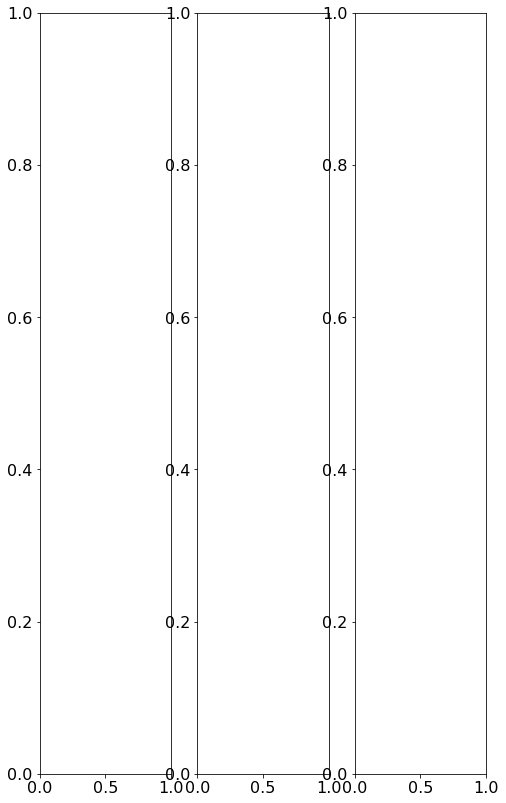

In [330]:
mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['font.size'] = 22
mpl.rcParams['axes.labelsize'] = 24
fs = 24

gamma = [1, 100, 10000]

fig, axes = plt.subplots(len(gamma), 3, figsize = (len(gamma) * 8, 14 ))
# suptitle = "RCP 8.5 - Anthropogenic forcing (" + str( endDate ) + ") - Anchor : Solar forcing ($\gamma$ = " + \
#                 str(gammaSeq[0]) + ")"
#fig.suptitle(suptitle, fontsize = 20)
#fig.subplots_adjust(top = 0.92)

N = X.shape[0]
selLambda = [1, 100, 1000]
cl = [0.0006, 0.003, 0.006] ### 2100
# cl = [0.003, 0.003, 0.003] ### 2005
#cl = [None, None, None]

residuals = np.zeros((Xt.shape[0], 3))

#  ----- No anchor -----
regr = linear_model.Ridge(alpha = X.shape[0] * selLambda[0] / 2 )
regr.fit(X, y)
y_test_pred = regr.predict(Xt)
coefStd = regr.coef_
coefRaw = np.transpose(coefStd) / np.array(std_X_train).reshape(X_train.shape[1], 1)   

# y_test_true = (yt - np.mean(yt)) / np.std(yt) * np.std(y_test.values) + np.mean(y_test.values)
# y_test_pred = (y_test_pred - np.mean(y_test_pred)) / np.std(y_test_pred) * np.std(y_test.values) + np.mean(y_test.values)

y_test_true = yt

residuals[:, 0] = (y_test_true - y_test_pred).reshape(-1) 

rmse = np.sqrt(np.mean((y_test_true - y_test_pred)**2)) 
r2 = r2_score(y_test_true, y_test_pred)

fig.sca(axes[0, 0])
plotBasemap_subplots(coefRaw.reshape(grid), cLim = cl[0], title_subplot = "Ridge regression (no anchor)\n Raw coefficients", fontSize = fs);

# fig.sca(axes[0, 1])
# plotBasemap_subplots(coefStd.reshape(grid), "Ridge regression (no anchor)\n Standardized coefficients", fontSize = fs);

fig.sca(axes[0, 1])
plt.plot(y_test_true, y_test_pred, '.')
plt.xlabel("True forcing")
plt.ylabel("Predicted forcing")

if forcing == "anthro": x = np.linspace(-1, 2.5, 100)
elif forcing == "GHG": x = np.linspace(-1, 2.5, 100)
elif forcing == "aerosols": x = np.linspace(-2, 2, 100)
elif forcing == "solar": x = np.linspace(-0.05, 0.20, 100)
elif forcing == "volcanic": x = np.linspace(-1.5, 0.25, 100)
elif forcing == "natural": x = np.linspace(-1.5, 0.50, 100)
elif forcing == "all": x = np.linspace(-1.5, 2.5, 100)

plt.plot(x, x, 'k', linestyle='solid')
plt.title("RMSE = " + str(np.round(rmse, 4)) + " --- R2 = " + str(np.round(r2, 4))) 

#fig.sca(axes[0, 3])
# axes[0, 3].plot(y_test_true, label = "True forcing")
# axes[0, 3].plot(y_test_pred, label = "Predicted forcing")
# axes[0, 3].legend()
# axes[0, 3].set_xlabel("Time/Model")
# axes[0, 3].set_ylabel("Forcing")

axes[0, 2].plot(w_test, residuals[:, 0], '.')
axes[0, 2].set_xlabel("Anchor " + constraintForcing.upper())
axes[0, 2].set_ylabel("Residuals " + forcing[:3].upper())
axes[0, 2].set_title("No anchor: corr ρ = " + str(np.round(np.corrcoef(np.transpose(w_test), \
                                                                  np.transpose(residuals[:, 0]))[0,1], 3)))

#plt.title("No constraint --- $λ = $" + str(lambda_val) + " --- RMSE = " + str(np.round(rmse,4)) + \
#              " --- R2 = " + str(np.round(r2,4)))
plt.legend()

# ------ Anchor regression 1 ------
gamma1 = 100
X_PA = ( np.mat(np.identity(N)) - PA ) * np.mat( X ) + np.sqrt( gamma1 ) * PA * np.mat( X )
y_PA = ( np.mat(np.identity(N)) - PA ) * np.mat( y ) + np.sqrt( gamma1 ) * PA * np.mat( y )
    
# Create a scaler object
sc_X_PA = StandardScaler(with_mean=True, with_std=True)
sc_y_PA = StandardScaler(with_mean=True, with_std=True)

# Fit the scaler to the data and transform
X_PA_std = sc_X_PA.fit_transform(X_PA)
y_PA_std = sc_y_PA.fit_transform(y_PA)
    
X_std_PA = X_PA.std(axis=0)

regr = linear_model.Ridge(alpha = X_train.shape[0] * selLambda[1] / 2)
regr.fit(X_PA, y_PA)
coefStd = regr.coef_
coefRaw = np.transpose(coefStd) / np.array(std_X_train).reshape(X.shape[1], 1)

# fig.sca(axes[1,1])
# plotBasemap_subplots(coefStd.reshape(grid), constraintForcing.capitalize() + " anchor ($\gamma = " + str(gamma1) + \
#                      "$)\n Standardized coefficients", fontSize = fs)

fig.sca(axes[1,0])
plotBasemap_subplots(coefRaw.reshape(grid), cLim = cl[1], title_subplot = constraintForcing.capitalize() + " anchor ($\gamma = " + str(gamma1) + \
                     "$)\n Raw coefficients", fontSize = fs)
    
y_test_pred = regr.predict(Xt)

# y_test_true = (yt - np.mean(yt)) / np.std(yt) * np.std(y_test.values) + np.mean(y_test.values)
# y_test_pred = (y_test_pred - np.mean(y_test_pred)) / np.std(y_test_pred) * np.std(y_test.values) + np.mean(y_test.values)

y_test_true = yt

residuals[:, 1] = (y_test_true - y_test_pred).reshape(-1)

fig.sca(axes[1, 1])
plt.plot(y_test_true, y_test_pred, '.')
plt.xlabel("True forcing")
plt.ylabel("Predicted forcing")

if forcing == "anthro": x = np.linspace(-1, 2.5, 100)
elif forcing == "GHG": x = np.linspace(-1, 2.5, 100)
elif forcing == "aerosols": x = np.linspace(-2, 2, 100)
elif forcing == "solar": x = np.linspace(-0.05, 0.20, 100)
elif forcing == "volcanic": x = np.linspace(-1.5, 0.25, 100)
elif forcing == "natural": x = np.linspace(-1.5, 0.50, 100)
elif forcing == "all": x = np.linspace(-1.5, 2.5, 100)

plt.plot(x, x, 'k', linestyle='solid')

rmse = np.sqrt(np.mean((y_test_true - y_test_pred)**2)) 
r2 = r2_score(y_test_true, y_test_pred)
plt.title("RMSE = " + str(np.round(rmse, 4)) + " --- R2 = " + str(np.round(r2, 4)))

# fig.sca(axes[1, 2])
# plt.plot(y_test_true, label = "True forcing")
# plt.plot(y_test_pred, label = "Predicted forcing")
# plt.xlabel("Time/Model")
# plt.ylabel("Forcing")
# plt.legend();

axes[1, 2].plot(w_test, residuals[:, 1], '.')
axes[1, 2].set_xlabel("Anchor " + constraintForcing.upper())
axes[1, 2].set_ylabel("Residuals " + forcing[:3].upper())
axes[1, 2].set_title(constraintForcing[:3].upper() + " anchor ($\gamma = " + str(gamma1) + "$) : corr ρ = " + \
             str(np.round(np.corrcoef(np.transpose(w_test), np.transpose(residuals[:, 1]))[0,1], 3)));

# ------ Anchor regression 2 ------
gamma2 = 10000
X_PA = ( np.mat(np.identity(N)) - PA ) * np.mat( X ) + np.sqrt( gamma2 ) * PA * np.mat( X )
y_PA = ( np.mat(np.identity(N)) - PA ) * np.mat( y ) + np.sqrt( gamma2 ) * PA * np.mat( y )
    
regr = linear_model.Ridge(alpha = X_train.shape[0] * selLambda[2] / 2)
regr.fit(X_PA, y_PA)
coefStd = regr.coef_
coefRaw = np.transpose(coefStd) / np.array(std_X_train).reshape(X.shape[1], 1)
#coefRaw = np.transpose(coefStd) / np.array(X_std_PA).reshape(X.shape[1], 1) 

# fig.sca(axes[2,1])
# plotBasemap_subplots(coefStd.reshape(grid), constraintForcing.capitalize() + " anchor ($\gamma = " + str(gamma2) + \
#                      "$)\n Standardized coefficients", fontSize = fs)

fig.sca(axes[2,0])
plotBasemap_subplots(coefRaw.reshape(grid), cLim = cl[2], title_subplot = constraintForcing.capitalize() + \
                     " anchor ($\gamma = " + str(gamma2) + "$)\n Raw coefficients", fontSize = fs)
    
y_test_pred = regr.predict(Xt)
#y_test_pred = np.matmul(Xt, coefRaw)

# y_test_true = (yt - np.mean(yt)) / np.std(yt) * np.std(y_test.values) + np.mean(y_test.values)
# y_test_pred = (y_test_pred - np.mean(y_test_pred)) / np.std(y_test_pred) * np.std(y_test.values) + np.mean(y_test.values)

y_test_true = yt

residuals[:, 2] = (y_test_true - y_test_pred).reshape(-1)

fig.sca(axes[2, 1])
plt.plot(y_test_true, y_test_pred, '.')
plt.xlabel("True forcing")
plt.ylabel("Predicted forcing")

if forcing == "anthro": x = np.linspace(-1, 2.5, 100)
elif forcing == "GHG": x = np.linspace(-1, 2.5, 100)
elif forcing == "aerosols": x = np.linspace(-2, 2, 100)
elif forcing == "solar": x = np.linspace(-0.05, 0.20, 100)
elif forcing == "volcanic": x = np.linspace(-1.5, 0.25, 100)
elif forcing == "natural": x = np.linspace(-1.5, 0.50, 100)
elif forcing == "all": x = np.linspace(-1.5, 2.5, 100)

plt.plot(x, x, 'k', linestyle = 'solid')

rmse = np.sqrt(np.mean((y_test_true - y_test_pred)**2)) 
r2 = r2_score(y_test_true, y_test_pred)
plt.title("RMSE = " + str(np.round(rmse, 4)) + " --- R2 = " + str(np.round(r2, 4)))

# fig.sca(axes[2, 3])
# plt.plot(y_test_true, label = "True forcing")
# plt.plot(y_test_pred, label = "Predicted forcing")
# plt.xlabel("Time/Model")
# plt.ylabel("Forcing")
# plt.legend();

axes[2, 2].plot(w_test, residuals[:, 2], '.')
axes[2, 2].set_xlabel("Anchor " + constraintForcing.upper())
axes[2, 2].set_ylabel("Residuals " + forcing[:3].upper())
axes[2, 2].set_title(constraintForcing[:3].upper() + " anchor ($\gamma = " + str(gamma2) + "$) : corr ρ = " + \
             str(np.round(np.corrcoef(np.transpose(w_test), np.transpose(residuals[:, 2]))[0,1], 3)));

plt.tight_layout()
#fig.savefig("coefAll.png", bbox_inches = "tight")

/home/eniko/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


ValueError: x and y must have same first dimension, but have shapes (1848, 1) and (3415104,)

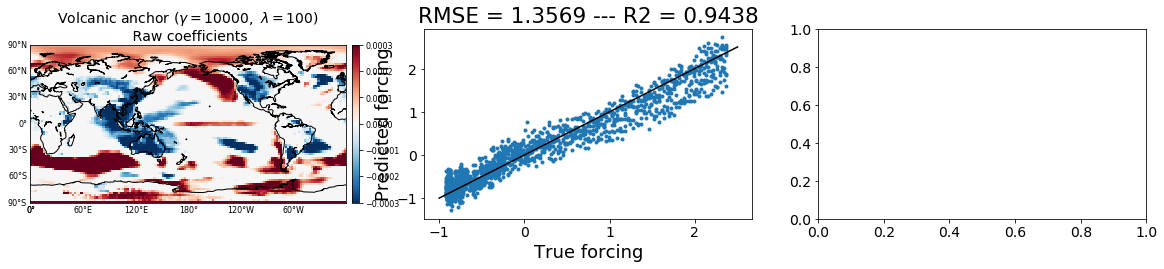

In [345]:
mpl.rcParams['xtick.labelsize'] = 14 
mpl.rcParams['ytick.labelsize'] = 14 
mpl.rcParams['font.size'] = 18
mpl.rcParams['axes.labelsize'] = 18
fs = 20

fig, axes = plt.subplots(1, 3, figsize = (20, 3.5 ))
# suptitle = "RCP 8.5 - Anthropogenic forcing (" + str( endDate ) + ") - Anchor : Solar forcing ($\gamma$ = " + \
#                 str(gammaSeq[0]) + ")"
#fig.suptitle(suptitle, fontsize = 20)
#fig.subplots_adjust(top = 0.92)

N = X.shape[0]
selLambda = 100
cl = 0.0003

residuals = np.zeros((Xt.shape[0], 3))

gamma2 = 10000
X_PA = ( np.mat(np.identity(N)) - PA ) * np.mat( X ) + np.sqrt( gamma2 ) * PA * np.mat( X )
y_PA = ( np.mat(np.identity(N)) - PA ) * np.mat( y ) + np.sqrt( gamma2 ) * PA * np.mat( y )
    
# regr = linear_model.Ridge(alpha = X_train.shape[0] * selLambda / 2, solver = 'cholesky')
# regr.fit(X_PA, y_PA)
# coefStd = regr.coef_
# #coefStd = coefStd / np.array(X_std_PA)
# coefRaw = np.transpose(coefStd) / np.array(std_X_train).reshape(X.shape[1], 1)
# #coefRaw = np.transpose(coefStd) / np.array(X_std_PA).reshape(X.shape[1], 1) 

regr = linear_model.ElasticNet(alpha = 100, l1_ratio = 0.0005)
regr.fit(X_PA, y_PA)
coefStd = regr.coef_.reshape(1, -1)
#coefStd = coefStd / np.array(X_std_PA)
coefRaw = np.transpose(coefStd) / np.array(std_X_train).reshape(X.shape[1], 1)

# fig.sca(axes[2,1])
# plotBasemap_subplots(coefStd.reshape(grid), constraintForcing.capitalize() + " anchor ($\gamma = " + str(gamma2) + \
#                      "$)\n Standardized coefficients", fontSize = fs)

fig.sca(axes[0])
plotBasemap_subplots(coefRaw.reshape(grid), cLim = cl, title_subplot = constraintForcing.capitalize() + \
                " anchor ($\gamma = " + str(gamma2) + ",\ \lambda = " + str(selLambda) + " $)\n Raw coefficients", \
                fontSize = 14)
    
y_test_pred = regr.predict(Xt)
#y_test_pred = np.matmul(Xt, np.transpose(coefStd))

# y_test_true = (yt - np.mean(yt)) / np.std(yt) * np.std(y_test.values) + np.mean(y_test.values)
# y_test_pred = (y_test_pred - np.mean(y_test_pred)) / np.std(y_test_pred) * np.std(y_test.values) + np.mean(y_test.values)

y_test_true = yt

residuals = (y_test_true - y_test_pred).reshape(-1)

fig.sca(axes[1])
plt.plot(y_test_true, y_test_pred, '.')
plt.xlabel("True forcing")
plt.ylabel("Predicted forcing")

if forcing == "anthro": x = np.linspace(-1, 2.5, 100)
elif forcing == "solar": x = np.linspace(-0.05, 0.20, 100)
elif forcing == "volcanic": x = np.linspace(-1.5, 0.25, 100)
elif forcing == "natural": x = np.linspace(-1.5, 0.50, 100)
elif forcing == "all": x = np.linspace(-1.5, 2.5, 100)

plt.plot(x, x, 'k', linestyle = 'solid')

rmse = np.sqrt(np.mean((y_test_true - y_test_pred)**2)) 
r2 = r2_score(y_test_true, y_test_pred)
plt.title("RMSE = " + str(np.round(rmse, 4)) + " --- R2 = " + str(np.round(r2, 4)))

# fig.sca(axes[2, 3])
# plt.plot(y_test_true, label = "True forcing")
# plt.plot(y_test_pred, label = "Predicted forcing")
# plt.xlabel("Time/Model")
# plt.ylabel("Forcing")
# plt.legend();

axes[2].plot(w_test, residuals, '.')
axes[2].set_xlabel("Forcing " + constraintForcing.upper())
axes[2].set_ylabel("Residuals " + forcing[:3].upper())
axes[2].set_title(constraintForcing[:3].upper() + " anchor ($\gamma = " + str(gamma2) + "$) : corr ρ = " + \
             str(np.round(np.corrcoef(np.transpose(w_test), np.transpose(residuals[:, 2]))[0,1], 3)));

plt.tight_layout()

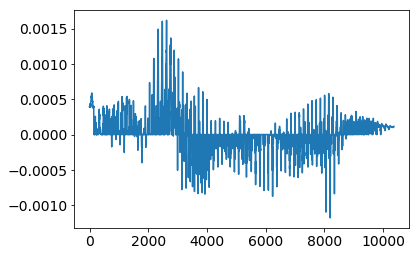

In [346]:
plt.plot(coefRaw)

In [ ]:
# y_test_true = (yt - np.mean(yt)) / np.std(yt) * np.std(y_test.values) + np.mean(y_test.values)
# y_test_pred = (y_test_pred - np.mean(y_test_pred)) / np.std(y_test_pred) * np.std(y_test.values) + np.mean(y_test.values)

In [33]:
stdev_year = np.zeros((231, 1))

for i in range(len(stdev_year.reshape(-1))):
#    stdev_year[i] = np.sqrt(sum((y_test_pred[i::231] - y_test_true[i::231])**2) / (len(y_test_pred[i::231]) - 2))
    stdev_year[i] = np.std(y_test_pred[i::231] - y_test_true[i::231])

In [34]:
dict_models["testFiles"]

['tas_ann_BNU-ESM_piControl_r1i1p1_g025.nc',
 'tas_ann_BNU-ESM_rcp85_r1i1p1_g025.nc',
 'tas_ann_CCSM4_piControl_r1i1p1_g025.nc',
 'tas_ann_CCSM4_rcp85_r1i1p1_g025.nc',
 'tas_ann_CSIRO-Mk3-6-0_piControl_r1i1p1_g025.nc',
 'tas_ann_CSIRO-Mk3-6-0_rcp85_r1i1p1_g025.nc',
 'tas_ann_GFDL-CM3_piControl_r1i1p1_g025.nc',
 'tas_ann_GFDL-CM3_rcp85_r1i1p1_g025.nc',
 'tas_ann_GFDL-ESM2G_piControl_r1i1p1_g025.nc',
 'tas_ann_GFDL-ESM2G_rcp85_r1i1p1_g025.nc',
 'tas_ann_GFDL-ESM2M_piControl_r1i1p1_g025.nc',
 'tas_ann_GFDL-ESM2M_rcp85_r1i1p1_g025.nc',
 'tas_ann_HadGEM2-AO_piControl_r1i1p1_g025.nc',
 'tas_ann_HadGEM2-AO_rcp85_r1i1p1_g025.nc',
 'tas_ann_HadGEM2-CC_piControl_r1i1p1_g025.nc',
 'tas_ann_HadGEM2-CC_rcp85_r1i1p1_g025.nc',
 'tas_ann_HadGEM2-ES_piControl_r1i1p1_g025.nc',
 'tas_ann_HadGEM2-ES_rcp85_r1i1p1_g025.nc']

In [51]:
modelsInfoFrame[modelsInfoFrame["filename"] == dict_models["testFiles"][4]]

filename  var temporalRes  \
21  tas_ann_CSIRO-Mk3-6-0_piControl_r1i1p1_g025.nc  tas         ann   

        modelFull model   scenario spatialRes  
21  CSIRO-Mk3-6-0   CSI  piControl       g025

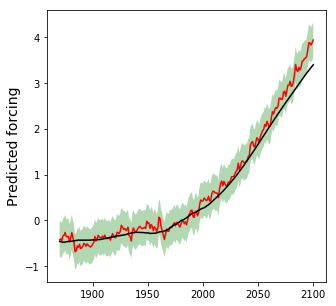

In [86]:
fig = plt.figure(figsize = (5,5))
m1, m2 = 18,19
nbStd = 1
z = 1.96
#xx = np.linspace(1, 231*m, 231*m)
xx = y_test.iloc[231 * m1: 231 * m2].index
#stdev = np.sqrt(sum((y_test_pred - y_test_true)**2) / (len(y_test) - 2))
stdev = np.std(y_test_pred - y_test_true)
plt.plot(xx, y_test_pred[231*m1:231*m2], 'r')
plt.plot(xx, y_test_true[231*m1:231*m2], 'k')
# plt.plot(xx, y_test_pred[231*m1:231*m2] - nbStd * 1.96 * stdev, 'g')
# plt.plot(xx, y_test_pred[231*m1:231*m2] + nbStd * 1.96 * stdev, 'g')
plt.fill(np.concatenate([xx, xx[::-1]]), 
         np.concatenate([y_test_pred[231*m1:231*m2].reshape(-1) - nbStd * z * stdev,
                        (y_test_pred[231*m1:231*m2].reshape(-1) + nbStd * z * stdev)[::-1]]),
         alpha=.3, fc='g', ec='None', label='95% confidence interval')
#plt.ylabel('Predicted forcing [W/m2]', fontsize = 14);
plt.ylabel('Predicted forcing', fontsize = 14);

In [ ]:
dict_models["testFiles"]

In [309]:
res = y_test_pred - y_test_true
pop_stdev = res.std()
margin_of_error = z * (pop_stdev/np.sqrt(len(y_test_true)))
margin_of_error

0.011790765275557459

In [305]:
np.std(res)

0.3106299133698564

In [306]:
stdev1 = np.sqrt(sum((y_test_pred - y_test_true)**2) / (len(y_test)))
stdev2 = np.std(y_test_pred - y_test_true)
print(stdev1)
print(stdev2)

[0.31062991]
0.3106299133698564


In [272]:
np.std(y_test_pred - y_test_true)

0.34171017300248896

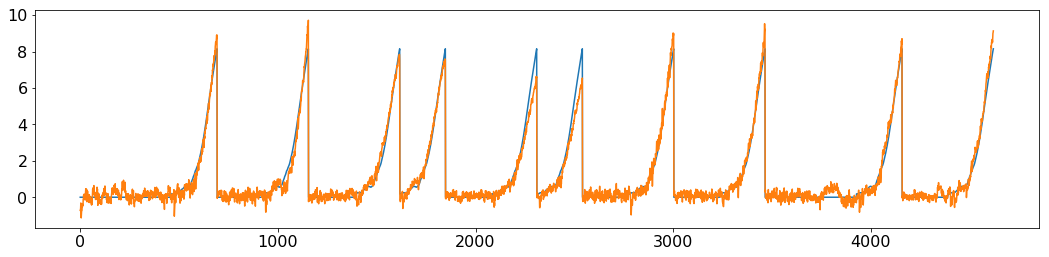

In [297]:
fig = plt.figure(figsize = (18,4))
plt.plot(y_test_true)
plt.plot(y_test_pred)

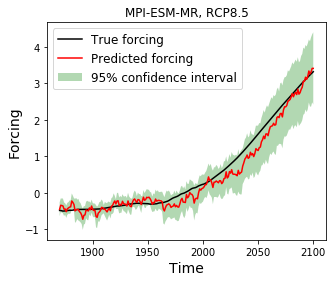

In [37]:
fig = plt.figure(figsize = (5,4))
m1, m2 = 13,14
nbStd = 1
z = 1.96
#xx = np.linspace(1, 231*m, 231*m)
xx = y_test.iloc[231 * m1: 231 * m2].index
stdev = np.sqrt(sum((y_test_pred - y_test_true)**2) / (len(y_test) - 2))
plt.plot(xx, y_test_true[231*m1:231*m2], 'k', label = "True forcing")
plt.plot(xx, y_test_pred[231*m1:231*m2], 'r', label = "Predicted forcing")
plt.fill(np.concatenate([xx, xx[::-1]]), 
         np.concatenate([y_test_pred[231*m1:231*m2] - z * stdev_year,
                        (y_test_pred[231*m1:231*m2] + z * stdev_year)[::-1]]),
         alpha=.3, fc='g', ec='None', label='95% confidence interval')
plt.xlabel('Time', fontsize = 14);
plt.ylabel('Forcing', fontsize = 14);
#plt.ylabel('Forcing [W/m2]', fontsize = 14);
plt.legend(fontsize = 12)
plt.title('MPI-ESM-MR, RCP8.5');

In [139]:
#fig.savefig("./../output/figures/confidenceIntervals/CI_MPI-ESM-MR_rcp85_timeDependent.eps", bbox_inches = "tight")

In [38]:
dict_models["testFiles"]

['tas_ann_BNU-ESM_piControl_r1i1p1_g025.nc',
 'tas_ann_BNU-ESM_rcp85_r1i1p1_g025.nc',
 'tas_ann_CCSM4_piControl_r1i1p1_g025.nc',
 'tas_ann_CCSM4_rcp85_r1i1p1_g025.nc',
 'tas_ann_CSIRO-Mk3-6-0_piControl_r1i1p1_g025.nc',
 'tas_ann_CSIRO-Mk3-6-0_rcp85_r1i1p1_g025.nc',
 'tas_ann_GFDL-CM3_piControl_r1i1p1_g025.nc',
 'tas_ann_GFDL-CM3_rcp85_r1i1p1_g025.nc',
 'tas_ann_GFDL-ESM2G_piControl_r1i1p1_g025.nc',
 'tas_ann_GFDL-ESM2G_rcp85_r1i1p1_g025.nc',
 'tas_ann_GFDL-ESM2M_piControl_r1i1p1_g025.nc',
 'tas_ann_GFDL-ESM2M_rcp85_r1i1p1_g025.nc',
 'tas_ann_HadGEM2-AO_piControl_r1i1p1_g025.nc',
 'tas_ann_HadGEM2-AO_rcp85_r1i1p1_g025.nc',
 'tas_ann_HadGEM2-CC_piControl_r1i1p1_g025.nc',
 'tas_ann_HadGEM2-CC_rcp85_r1i1p1_g025.nc',
 'tas_ann_HadGEM2-ES_piControl_r1i1p1_g025.nc',
 'tas_ann_HadGEM2-ES_rcp85_r1i1p1_g025.nc']

In [43]:
dict_models["testFiles"]

18.0

In [ ]:

fig = plt.figure(figsize = (7,4))
m1, m2 = 1,2
#xx = np.linspace(1, 231*m, 231*m)
xx = y_test.iloc[231 * m1: 231 * m2].index
stdev = np.sqrt(sum((y_test_pred - y_test_true)**2) / (len(y_test) - 2))
plt.plot(xx, y_test_pred[231*m1:231*m2], 'r')
plt.plot(xx, y_test_true[231*m1:231*m2], 'k')
plt.fill(np.concatenate([xx, xx[::-1]]), 
         np.concatenate([y_test_pred[231*m1:231*m2].reshape(-1) - 1.96 * stdev,
                        (y_test_pred[231*m1:231*m2].reshape(-1) + 1.96 * stdev)[::-1]]),
         alpha=.3, fc='g', ec='None', label='95% confidence interval')
#plt.ylabel('Predicted forcing [W/m2]', fontsize = 14);
plt.ylabel('Predicted forcing', fontsize = 14);

In [ ]:
fig = plt.figure(figsize = (7,4))
m1, m2 = 1,2
#xx = np.linspace(1, 231*m, 231*m)
xx = y_test.iloc[231 * m1: 231 * m2].index
stdev = np.sqrt(sum((y_test_pred - y_test_true)**2) / (len(y_test) - 2))
plt.plot(xx, y_test_pred[231*m1:231*m2], 'r')
plt.plot(xx, y_test_true[231*m1:231*m2], 'k')
plt.fill(np.concatenate([xx, xx[::-1]]), 
         np.concatenate([y_test_pred[231*m1:231*m2] - 1.96 * stdev_year,
                        (y_test_pred[231*m1:231*m2] + 1.96 * stdev_year)[::-1]]),
         alpha=.3, fc='g', ec='None', label='95% confidence interval')
#plt.ylabel('Predicted forcing [W/m2]', fontsize = 14);
plt.ylabel('Predicted forcing', fontsize = 14);

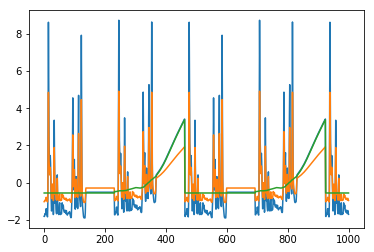

In [11]:
plt.plot(y_PA[:1000])
plt.plot(y_PA_std[:1000])
plt.plot(y[:1000])

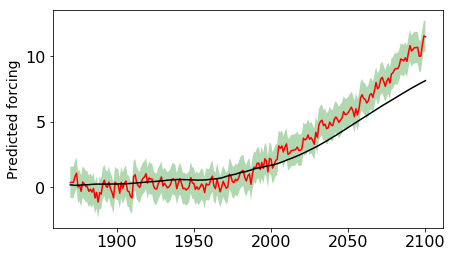

In [204]:
y_test_true = (yt - np.mean(yt)) / np.std(yt) * np.std(y_test.values) + np.mean(y_test.values)
y_test_pred = (y_test_pred - np.mean(y_test_pred)) / np.std(y_test_pred) * np.std(y_test.values) + np.mean(y_test.values)

fig = plt.figure(figsize = (7,4))
m1, m2 = 1,2
#xx = np.linspace(1, 231*m, 231*m)
xx = y_test.iloc[231 * m1: 231 * m2].index
stdev = np.sqrt(sum((y_test_pred - y_test_true)**2) / (len(y_test) - 2))
plt.plot(xx, y_test_pred[231*m1:231*m2], 'r')
plt.plot(xx, y_test_true[231*m1:231*m2], 'k')
plt.fill(np.concatenate([xx, xx[::-1]]), 
         np.concatenate([y_test_pred[231*m1:231*m2].reshape(-1) - 1.96 * stdev,
                        (y_test_pred[231*m1:231*m2].reshape(-1) + 1.96 * stdev)[::-1]]),
         alpha=.3, fc='g', ec='None', label='95% confidence interval')
#plt.ylabel('Predicted forcing [W/m2]', fontsize = 14);
plt.ylabel('Predicted forcing', fontsize = 14);

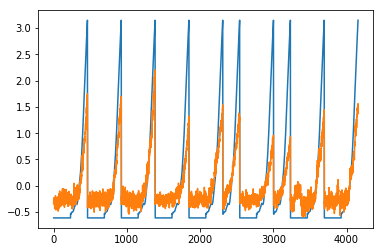

In [12]:
plt.plot(y_test_true)
plt.plot(y_test_pred)

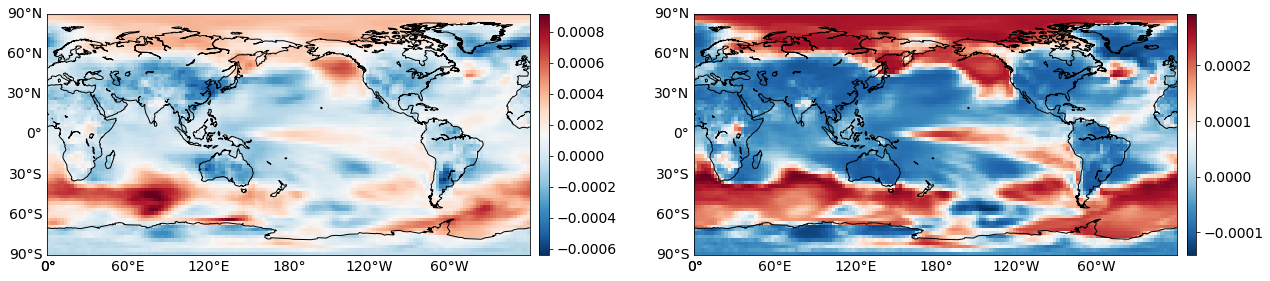

In [17]:
fig, axes = plt.subplots(1, 2, figsize = (18, 4))

selLambda = 1000

regr = linear_model.Ridge(alpha = X_train.shape[0] * selLambda / 2)
#regr = linear_model.LinearRegression()

regr.fit(X_PA, y_PA)
coefRawDirect = regr.coef_
fig.sca(axes[0])
plotBasemap_subplots(coefRawDirect.reshape(grid))

regr.fit(X_PA_std, y_PA_std)
coefStd = regr.coef_
coefRawIndirect = coefStd / np.array(X_std_PA)
fig.sca(axes[1])
plotBasemap_subplots(coefRawIndirect.reshape(grid))

plt.tight_layout()

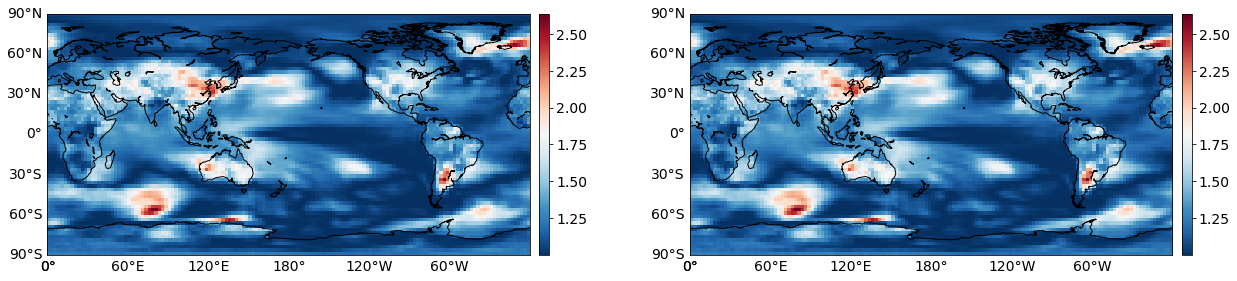

In [18]:
fig, axes = plt.subplots(1, 2, figsize = (18, 4))

fig.sca(axes[0])
plotBasemap_subplots(X_std_PA.reshape(grid))

fig.sca(axes[1])
plotBasemap_subplots(sc_X_PA.scale_.reshape(-1,1).reshape(grid))

plt.tight_layout()

In [148]:
np.sum(sc_X_PA.scale_.reshape(-1,1)-X_std_PA)

1.9414528651395813e-08

In [164]:
#fig.savefig("./../output/figures/figsPres/anchor_rcp85_all_2100_anchorVolcanic_lambda1000_exp2.eps")

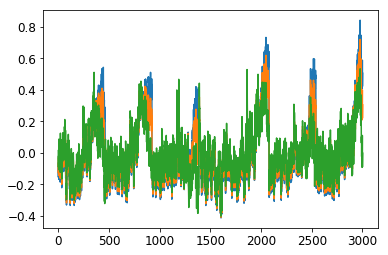

In [146]:
plt.plot(residuals[:,0])
plt.plot(residuals[:,1])
plt.plot(residuals[:,2])

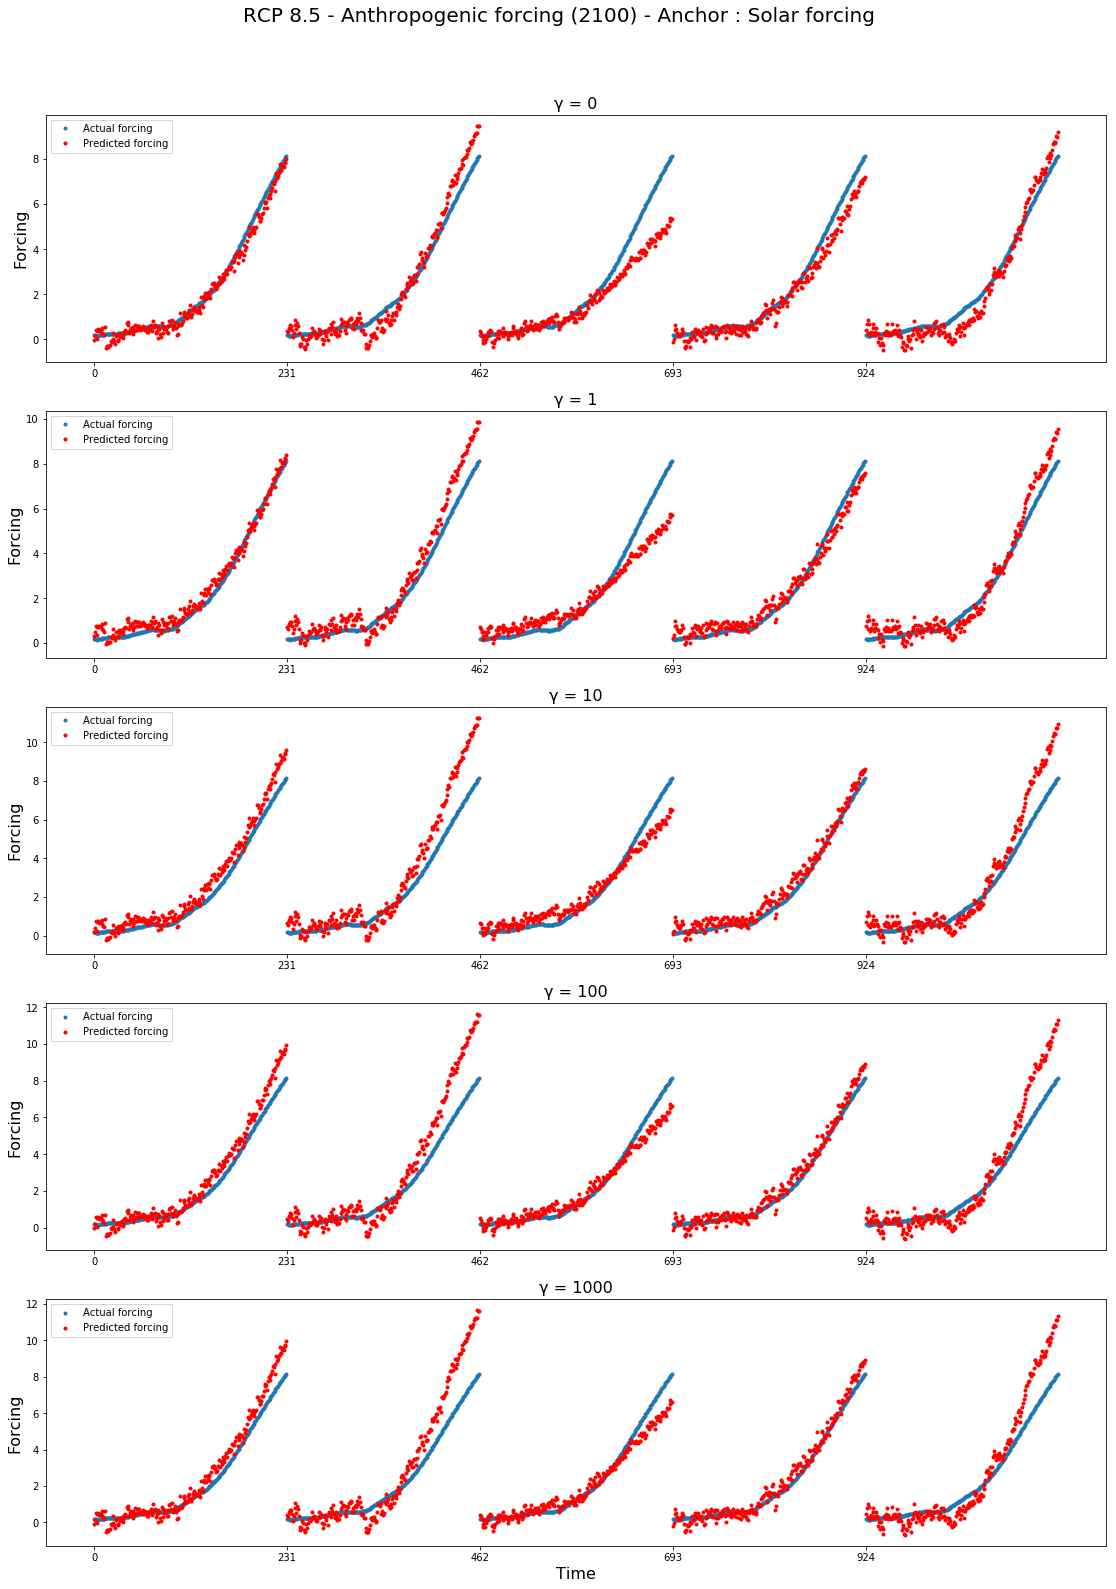

In [31]:
A_test = np.zeros( (nbTest * nbYearsPerModel, 1) )
#A[:,0] = np.tile( np.array(radForcing_df_rcp85_solar).reshape(-1), nbTrain )
#A[:,1] = np.tile( np.array(radForcing_df_rcp85_volcanic).reshape(-1), nbTrain )
A_test[:,0] = np.tile( np.array(radForcing_df_rcp85_solar).reshape(-1), nbTest )
A_test = np.mat( A_test ) # important for matrix multiplication (* doesn't act the same on matrices or arrays)
PA_test = A_test * np.linalg.inv( np.transpose(A_test) * A_test ) * np.transpose(A_test)

X = X_train
Xt = X_test
y = y_train
yt = y_test

Nt = Xt.shape[0]

X_std = X_train.std(axis=0)

N = X.shape[0]
selLambda = 5000 * X.shape[0] / 2    

gammaSeq = np.array([0, 1, 10, 100, 1000])

fig, axes = plt.subplots(len(gammaSeq), 1, figsize = (19, 5*len(gammaSeq)))
suptitle = "RCP 8.5 - Anthropogenic forcing (" + str( endDate ) + ") - Anchor : Solar forcing"
fig.suptitle(suptitle, fontsize = 20)
fig.subplots_adjust(top = 0.92)

for i in range(gammaSeq.shape[0]):
    X_PA = ( np.mat(np.identity(N)) - PA ) * np.mat( X ) + np.sqrt( gammaSeq[i] ) * PA * np.mat( X )
    y_PA = ( np.mat(np.identity(N)) - PA ) * np.mat( y ) + np.sqrt( gammaSeq[i] ) * PA * np.mat( y )
    
    X_std_PA = X_PA.std(axis = 0)

    regr = linear_model.Ridge(alpha = selLambda)
    regr.fit(X_PA, y_PA)
    
    Xt_PA = ( np.mat(np.identity(Nt)) - PA_test ) * np.mat( Xt ) + np.sqrt( gammaSeq[i] ) * PA_test * np.mat( Xt )
    yt_PA = ( np.mat(np.identity(Nt)) - PA_test ) * np.mat( yt ) + np.sqrt( gammaSeq[i] ) * PA_test * np.mat( yt )
    
    y_test_pred = regr.predict(Xt)    

    fig.sca(axes[i])
    axes[i].plot(np.array(yt), '.', label = "Actual forcing")
    axes[i].plot(y_test_pred, 'r.', label = "Predicted forcing")
    #axes[i].set_xlabel("Time", fontsize = 16)
    axes[i].set_ylabel("Forcing", fontsize = 16)
    axes[i].xaxis.set_ticks(np.arange(0, nbYearsPerModel * nbTest, nbYearsPerModel))
    axes[i].legend()
    axes[i].set_title("γ = " + str(gammaSeq[i]), fontsize = 16)

axes[i].set_xlabel("Time", fontsize = 16);
#fig.savefig("predictAll.png", bbox_inches = "tight")

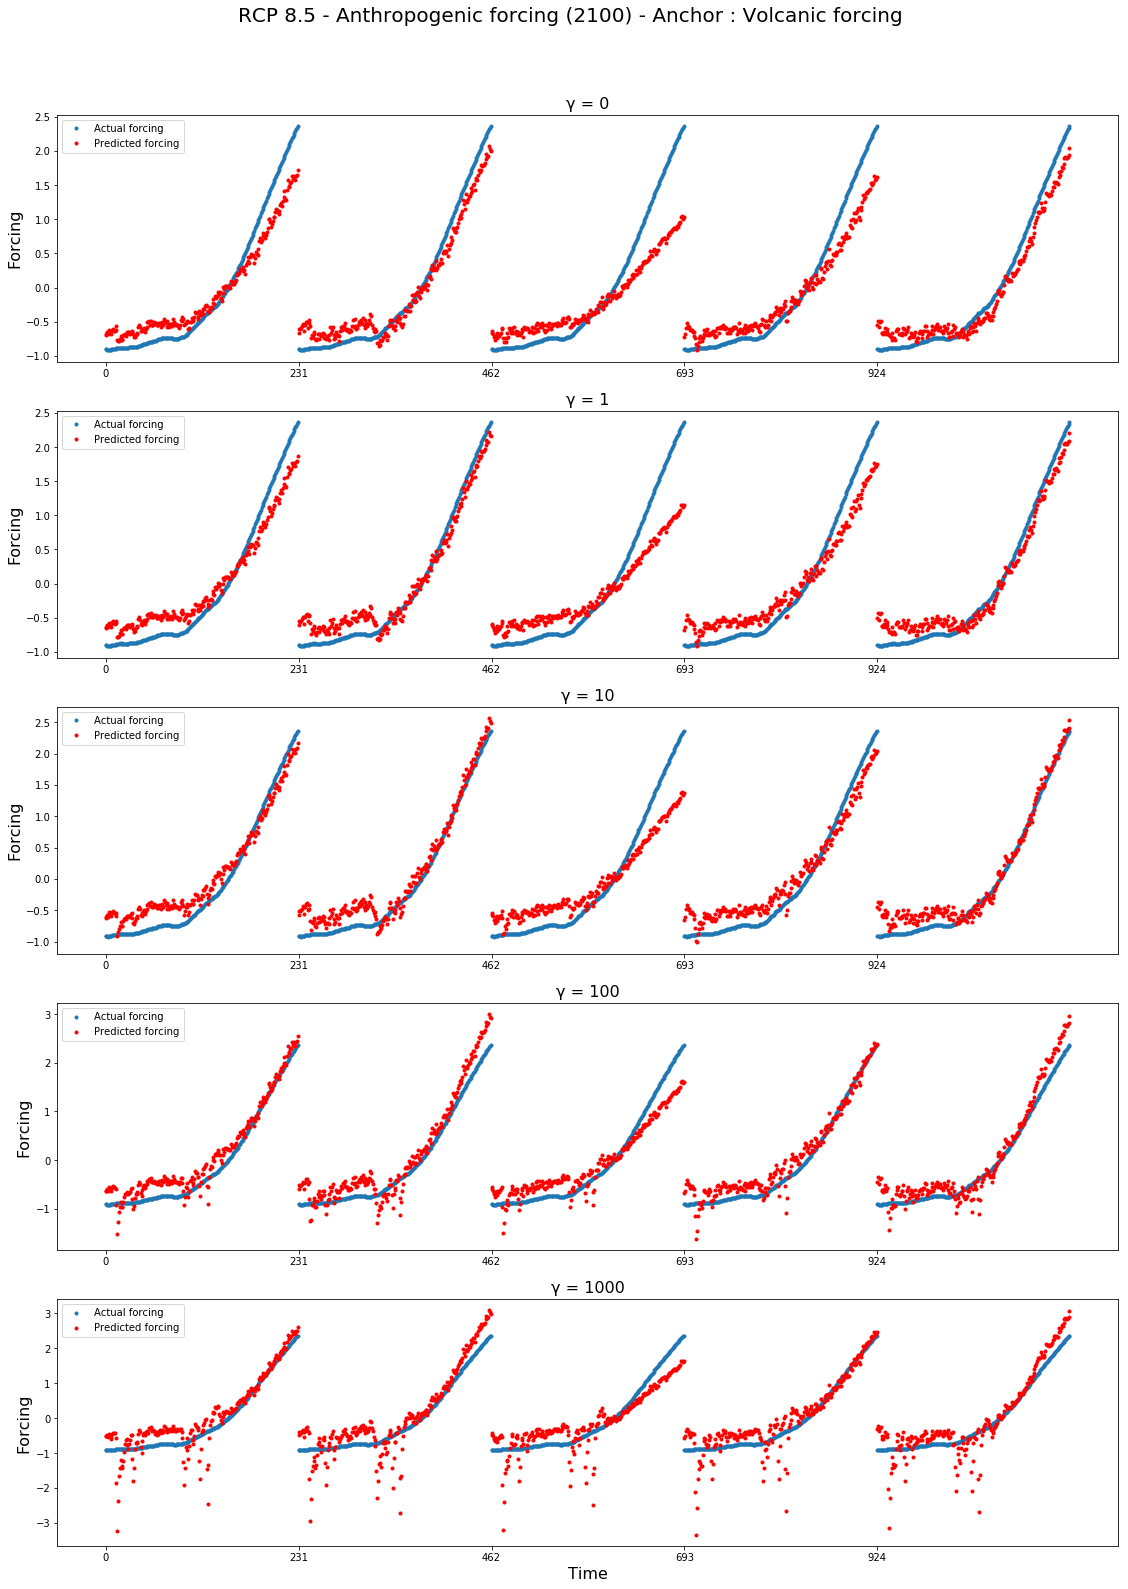

In [28]:
A_test = np.zeros( (nbTest * nbYearsPerModel, 1) )
#A[:,0] = np.tile( np.array(radForcing_df_rcp85_solar).reshape(-1), nbTrain )
#A[:,1] = np.tile( np.array(radForcing_df_rcp85_volcanic).reshape(-1), nbTrain )
A_test[:,0] = np.tile( np.array(radForcing_df_rcp85_volcanic).reshape(-1), nbTest )
A_test = np.mat( A_test ) # important for matrix multiplication (* doesn't act the same on matrices or arrays)
PA_test = A_test * np.linalg.inv( np.transpose(A_test) * A_test ) * np.transpose(A_test)

X = X_train_std
Xt = X_test_std
y = y_train_std
yt = y_test_std

Nt = Xt.shape[0]

X_std = X_train.std(axis=0)

N = X.shape[0]
selLambda = 5000 * X.shape[0] / 2    

gammaSeq = np.array([0, 1, 10, 100, 1000])

fig, axes = plt.subplots(len(gammaSeq), 1, figsize = (19, 5*len(gammaSeq)))
suptitle = "RCP 8.5 - Anthropogenic forcing (" + str( endDate ) + ") - Anchor : Volcanic forcing"
fig.suptitle(suptitle, fontsize = 20)
fig.subplots_adjust(top = 0.92)

for i in range(gammaSeq.shape[0]):
    X_PA = ( np.mat(np.identity(N)) - PA ) * np.mat( X ) + np.sqrt( gammaSeq[i] ) * PA * np.mat( X )
    y_PA = ( np.mat(np.identity(N)) - PA ) * np.mat( y ) + np.sqrt( gammaSeq[i] ) * PA * np.mat( y )
    
    X_std_PA = X_PA.std(axis = 0)

    regr = linear_model.Ridge(alpha = selLambda)
    regr.fit(X_PA, y_PA)
    
    Xt_PA = ( np.mat(np.identity(Nt)) - PA_test ) * np.mat( Xt ) + np.sqrt( gammaSeq[i] ) * PA_test * np.mat( Xt )
    yt_PA = ( np.mat(np.identity(Nt)) - PA_test ) * np.mat( yt ) + np.sqrt( gammaSeq[i] ) * PA_test * np.mat( yt )
    
    y_test_pred = regr.predict(Xt_PA)    

    fig.sca(axes[i])
    axes[i].plot(np.array(yt), '.', label = "Actual forcing")
    axes[i].plot(y_test_pred, 'r.', label = "Predicted forcing")
    #axes[i].set_xlabel("Time", fontsize = 16)
    axes[i].set_ylabel("Forcing", fontsize = 16)
    axes[i].xaxis.set_ticks(np.arange(0, nbYearsPerModel * nbTest, nbYearsPerModel))
    axes[i].legend()
    axes[i].set_title("γ = " + str(gammaSeq[i]), fontsize = 16)

axes[i].set_xlabel("Time", fontsize = 16);
#fig.savefig("predictAll.png", bbox_inches = "tight")

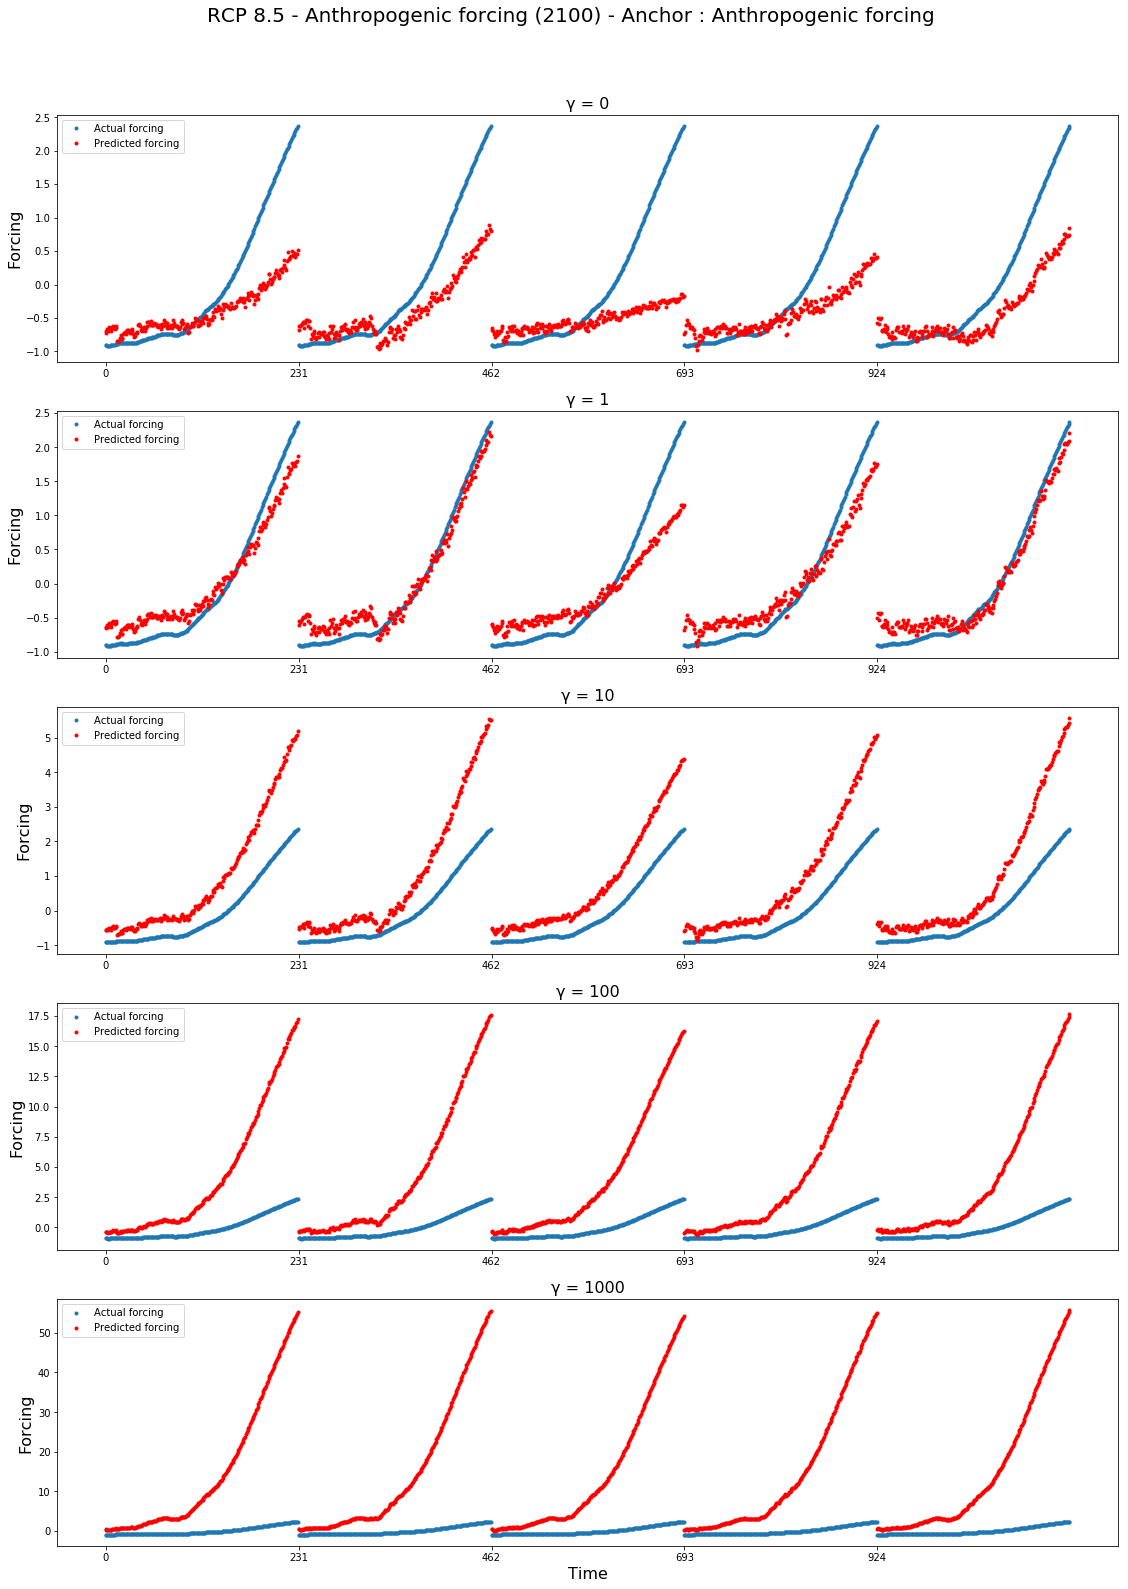

In [29]:
# A in R^(n,q) with q = nb of anchors

A = np.zeros( (nbTrain * nbYearsPerModel, 1) )
#A[:,0] = np.tile( np.array(radForcing_df_rcp85_solar).reshape(-1), nbTrain )
#A[:,1] = np.tile( np.array(radForcing_df_rcp85_volcanic).reshape(-1), nbTrain )
A[:,0] = np.tile( np.array(radForcing_df_rcp85).reshape(-1), nbTrain )
A = np.mat( A ) # important for matrix multiplication (* doesn't act the same on matrices or arrays)
PA = A * np.linalg.inv( np.transpose(A) * A ) * np.transpose(A)

A_test = np.zeros( (nbTest * nbYearsPerModel, 1) )
#A[:,0] = np.tile( np.array(radForcing_df_rcp85_solar).reshape(-1), nbTrain )
#A[:,1] = np.tile( np.array(radForcing_df_rcp85_volcanic).reshape(-1), nbTrain )
A_test[:,0] = np.tile( np.array(radForcing_df_rcp85).reshape(-1), nbTest )
A_test = np.mat( A_test ) # important for matrix multiplication (* doesn't act the same on matrices or arrays)
PA_test = A_test * np.linalg.inv( np.transpose(A_test) * A_test ) * np.transpose(A_test)

X = X_train_std
Xt = X_test_std
y = y_train_std
yt = y_test_std

Nt = Xt.shape[0]

X_std = X_train.std(axis=0)

N = X.shape[0]
selLambda = 5000 * X.shape[0] / 2    

gammaSeq = np.array([0, 1, 10, 100, 1000])

fig, axes = plt.subplots(len(gammaSeq), 1, figsize = (19, 5*len(gammaSeq)))
suptitle = "RCP 8.5 - Anthropogenic forcing (" + str( endDate ) + ") - Anchor : Anthropogenic forcing"
fig.suptitle(suptitle, fontsize = 20)
fig.subplots_adjust(top = 0.92)

for i in range(gammaSeq.shape[0]):
    X_PA = ( np.mat(np.identity(N)) - PA ) * np.mat( X ) + np.sqrt( gammaSeq[i] ) * PA * np.mat( X )
    y_PA = ( np.mat(np.identity(N)) - PA ) * np.mat( y ) + np.sqrt( gammaSeq[i] ) * PA * np.mat( y )
    
    X_std_PA = X_PA.std(axis = 0)

    regr = linear_model.Ridge(alpha = selLambda)
    regr.fit(X_PA, y_PA)
    
    Xt_PA = ( np.mat(np.identity(Nt)) - PA_test ) * np.mat( Xt ) + np.sqrt( gammaSeq[i] ) * PA_test * np.mat( Xt )
    yt_PA = ( np.mat(np.identity(Nt)) - PA_test ) * np.mat( yt ) + np.sqrt( gammaSeq[i] ) * PA_test * np.mat( yt )
    
    y_test_pred = regr.predict(Xt_PA)    

    fig.sca(axes[i])
    axes[i].plot(np.array(yt), '.', label = "Actual forcing")
    axes[i].plot(y_test_pred, 'r.', label = "Predicted forcing")
    #axes[i].set_xlabel("Time", fontsize = 16)
    axes[i].set_ylabel("Forcing", fontsize = 16)
    axes[i].xaxis.set_ticks(np.arange(0, nbYearsPerModel * nbTest, nbYearsPerModel))
    axes[i].legend()
    axes[i].set_title("γ = " + str(gammaSeq[i]), fontsize = 16)

axes[i].set_xlabel("Time", fontsize = 16);
#fig.savefig("predictAll.png", bbox_inches = "tight")

In [245]:
#fig.savefig("./../output/figures/anchorRegression/anchor_volcanic_solar_2005_2.png", quality = 100, bbox_inches = "tight")

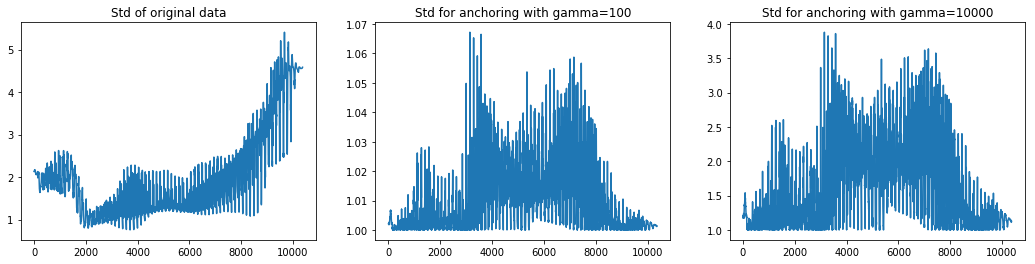

In [55]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(18,4)) 
ax1.plot(np.std(np.array(X_train), axis = 0).reshape(-1,1))
ax1.set_title("Std of original data")

X_PA = ( np.mat(np.identity(N)) - PA ) * np.mat( X ) + np.sqrt( 100 ) * PA * np.mat( X )
ax2.plot(np.std(X_PA, axis = 0).reshape(-1,1))
ax2.set_title("Std for anchoring with gamma=100")

X_PA = ( np.mat(np.identity(N)) - PA ) * np.mat( X ) + np.sqrt( 10000 ) * PA * np.mat( X )
ax3.plot(np.std(X_PA, axis = 0).reshape(-1,1))
ax3.set_title("Std for anchoring with gamma=10000");

Text(0.5,1,'Mean for anchoring with gamma=10000')

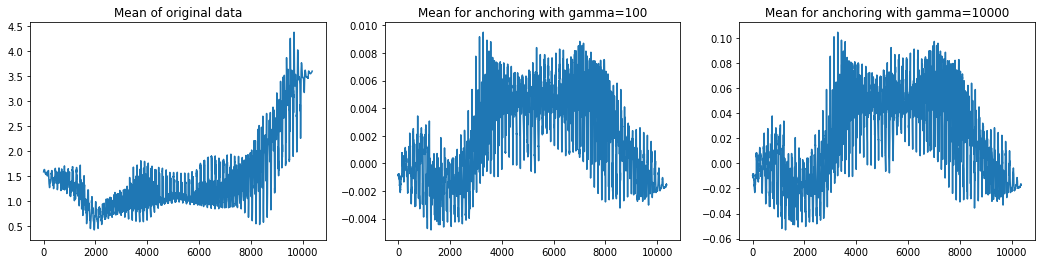

In [71]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(18,4)) 
ax1.plot(np.mean(np.array(X_train), axis = 0).reshape(-1,1))
ax1.set_title("Mean of original data")

X_PA = ( np.mat(np.identity(N)) - PA ) * np.mat( X ) + np.sqrt( 100 ) * PA * np.mat( X )
ax2.plot(np.mean(X_PA, axis = 0).reshape(-1,1))
ax2.set_title("Mean for anchoring with gamma=100")

X_PA = ( np.mat(np.identity(N)) - PA ) * np.mat( X ) + np.sqrt( 10000 ) * PA * np.mat( X )
ax3.plot(np.mean(X_PA, axis = 0).reshape(-1,1))
ax3.set_title("Mean for anchoring with gamma=10000");

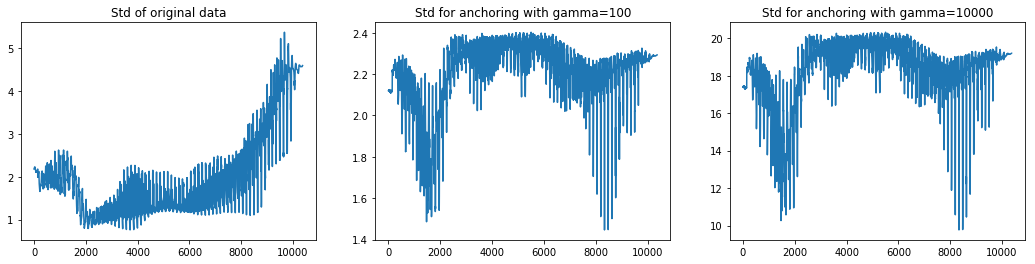

In [73]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(18,4)) 
ax1.plot(np.std(np.array(X_train), axis = 0).reshape(-1,1))
ax1.set_title("Std of original data")

X_PA = ( np.mat(np.identity(N)) - PA ) * np.mat( X ) + np.sqrt( 100 ) * PA * np.mat( X )
ax2.plot(np.std(X_PA, axis = 0).reshape(-1,1))
ax2.set_title("Std for anchoring with gamma=100")

X_PA = ( np.mat(np.identity(N)) - PA ) * np.mat( X ) + np.sqrt( 10000 ) * PA * np.mat( X )
ax3.plot(np.std(X_PA, axis = 0).reshape(-1,1))
ax3.set_title("Std for anchoring with gamma=10000");

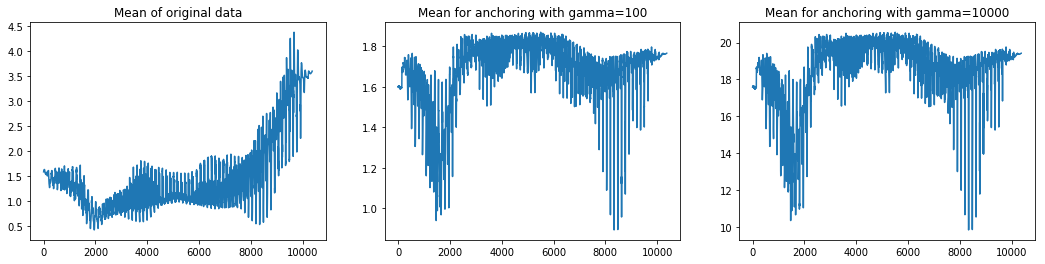

In [74]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(18,4)) 
ax1.plot(np.mean(np.array(X_train), axis = 0).reshape(-1,1))
ax1.set_title("Mean of original data")

X_PA = ( np.mat(np.identity(N)) - PA ) * np.mat( X ) + np.sqrt( 100 ) * PA * np.mat( X )
ax2.plot(np.mean(X_PA, axis = 0).reshape(-1,1))
ax2.set_title("Mean for anchoring with gamma=100")

X_PA = ( np.mat(np.identity(N)) - PA ) * np.mat( X ) + np.sqrt( 10000 ) * PA * np.mat( X )
ax3.plot(np.mean(X_PA, axis = 0).reshape(-1,1))
ax3.set_title("Mean for anchoring with gamma=10000");

### Standard regression

In [10]:
# Read data
trainData_listFolds, trainForcing_listFolds, X_test, y_test = generateData(dataType, dataNorm, nbModels, \
                                                                           nbTrain, nbFoldsCV, nbYearsPerModel)

X_train = pd.DataFrame()
y_train = pd.DataFrame()

for i in range(len(trainData_listFolds)):
    X_train = pd.concat([X_train, trainData_listFolds[i]], axis = 0)
    y_train = pd.concat([y_train, trainForcing_listFolds[i]], axis = 0)

# Create a scaler object
sc_X = StandardScaler(with_mean=True, with_std=True)
sc_y = StandardScaler(with_mean=True, with_std=True)

# Fit the scaler to the data and transform
X_train_std = sc_X.fit_transform(X_train)
y_train_std = sc_y.fit_transform(y_train)

X = X_train_std
y = y_train_std

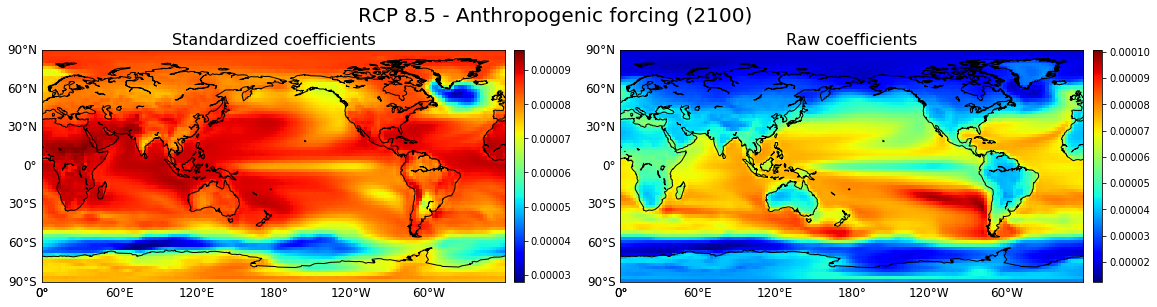

In [11]:
fig, axes = plt.subplots(1, 2, figsize = (19, 5))
suptitle = "RCP 8.5 - Anthropogenic forcing (" + str( endDate ) + ")"
fig.suptitle(suptitle, fontsize = 20)
fig.subplots_adjust(top = 0.95)

selLambda = 5000 * X.shape[0]/2
X_std = X_train.std(axis = 0)

regr = linear_model.Ridge(alpha = selLambda)
regr.fit(X, y)

coefStd = regr.coef_
title = "Standardized coefficients"
fig.sca(axes[0])
plotBasemap_subplots(coefStd.reshape(funcResolution(grid)), title, None)

coefRaw = np.transpose(coefStd) / np.array(X_std).reshape(X.shape[1], 1)
title = "Raw coefficients"
fig.sca(axes[1])
plotBasemap_subplots(coefRaw.reshape(funcResolution(grid)), title, None)

### Preprocessing (remove global mean, solar and volcanic forcing)

In [87]:
dict_models = generateData(modelsDataList, modelsInfoFrame, forcing, nbFoldsCV = 3, displayModels = False)

X_train = pd.DataFrame()
y_train = pd.DataFrame()
X_test = dict_models["X_test"]
y_test = dict_models["y_test"]

for i in range(len(dict_models["trainData_listFolds"])):
    X_train = pd.concat([X_train, dict_models["trainData_listFolds"][i]], axis = 0)
    y_train = pd.concat([y_train, dict_models["trainForcing_listFolds"][i]], axis = 0) 
    
# Create a scaler object
sc_X = StandardScaler(with_mean=True, with_std=True)
sc_X_test = StandardScaler(with_mean=True, with_std=True)
sc_y = StandardScaler(with_mean=True, with_std=True)
sc_y_test = StandardScaler(with_mean=True, with_std=True)

# Fit the scaler to the data and transform
X_train_std = sc_X.fit_transform(X_train.values)
X_test_std = sc_X_test.fit_transform(X_test.values)
y_train_std = sc_y.fit_transform(y_train.values)
y_test_std = sc_y_test.fit_transform(y_test.values)

# X = X_train_std
# Xt = X_test_std
# y = y_train_std
# y_test_true = y_test_std

# X_std = X_train.std(axis = 0)

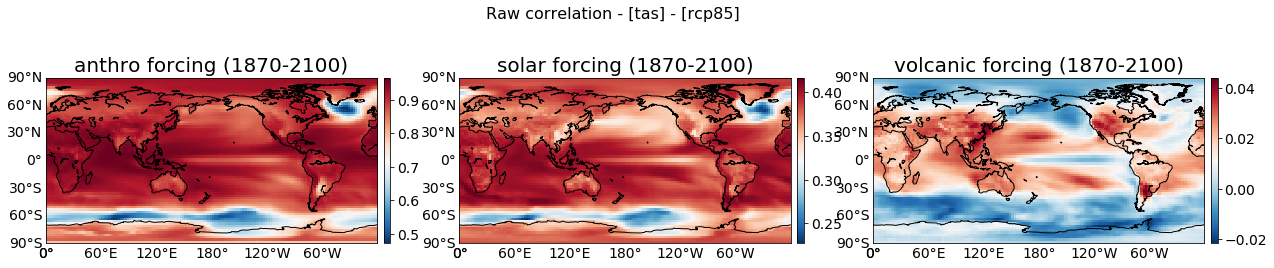

In [81]:
forcings = ["anthro", "solar", "volcanic"]

fig, axes = plt.subplots(1, len(forcings), figsize = (7 * len(forcings), 5))
suptitle = "Raw correlation - [" + ", ".join(variables) + "] - [" + ", ".join(scenarios) + "]"
fig.suptitle(suptitle, fontsize = 16)
fig.subplots_adjust(top = 0.98)

for i in range(len(forcings)):
    dict_models_corr = generateData(modelsDataList, modelsInfoFrame, forcings[i], displayModels = False)

    X_train = pd.DataFrame()
    y_train = pd.DataFrame()

    for j in range(len(dict_models_corr["trainData_listFolds"])):
        X_train = pd.concat([X_train, dict_models_corr["trainData_listFolds"][j]], axis = 0)
        y_train = pd.concat([y_train, dict_models_corr["trainForcing_listFolds"][j]], axis = 0)
    
    corr = np.zeros(X_train.shape[1])
    corr = np.array([pearsonr(X_train.iloc[:,k], y_train.values.reshape(-1))[0] for k in range(corr.shape[0])])
    title = forcings[i] + " forcing (" + str(startDate) + "-" + str(endDate) + ")"
    fig.sca(axes[i])
    plotBasemap_subplots(corr.reshape(grid), title_subplot = title)

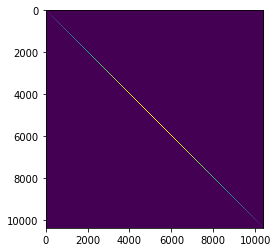

In [21]:
gridFile = np.load("./../data/gridInfo.npz")
lat = gridFile['lat']

W = np.tile( np.cos(lat.reshape(-1,1) * pi/180), 144)
W = np.diag(W.reshape( 72 * 144 ))
plt.imshow(W)
W = np.mat(W)

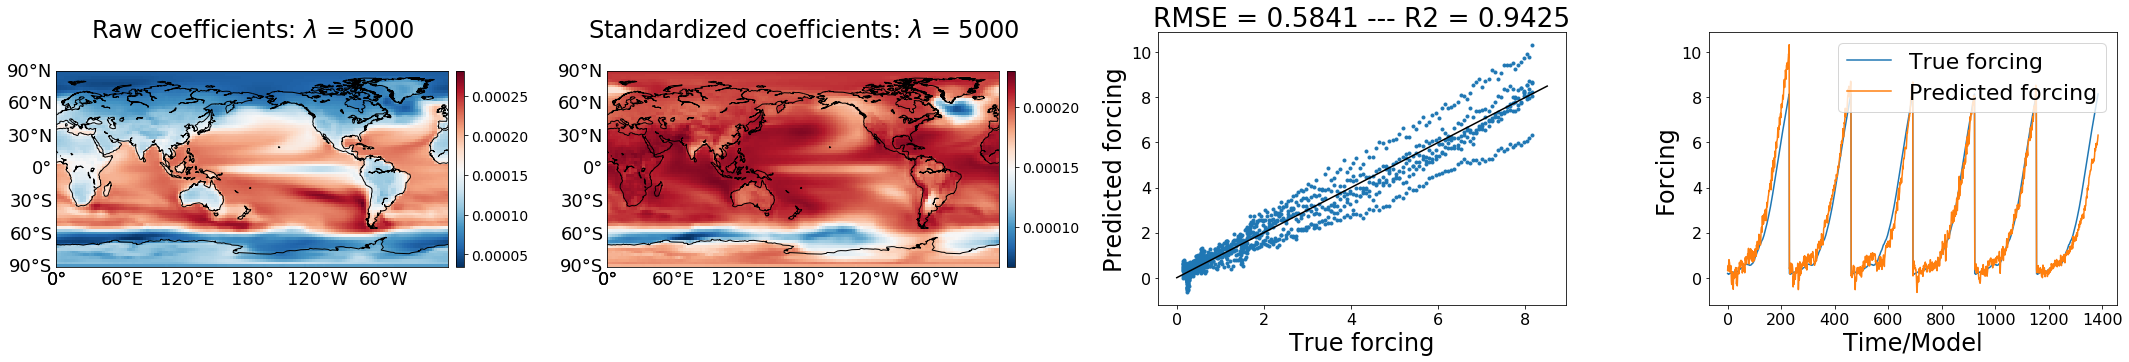

In [91]:
mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['font.size'] = 22
mpl.rcParams['axes.labelsize'] = 24
fs = 24

lambdaSeq = np.sort(np.array([5000]))

fig, axes = plt.subplots(len(lambdaSeq), 4, figsize = (30, 5.5*len(lambdaSeq) ))
# suptitle = "[" + ', '.join(scenarios) + "] -- Prediction: " + forcing + " forcing"
# fig.suptitle(suptitle, fontsize = 30)
# fig.subplots_adjust(top = 0.92)

if len(lambdaSeq) == 1:
    axes = axes.reshape(1, -1)
    
for i in range(lambdaSeq.shape[0]):
    regr = linear_model.Ridge(X.shape[0] * lambdaSeq[i] / 2)
#    regr = linear_model.Ridge(lambdaSeq[i])
    regr.fit(X, y)
    coefStd = regr.coef_
    coefRaw = np.transpose(coefStd) / np.array(std_X_train).reshape(X_train.shape[1], 1)
    y_test_pred = regr.predict(Xt)
    y_test_true = (y_test_true - np.mean(y_test_true)) / np.std(y_test_true) * np.std(y_test.values) + np.mean(y_test.values)
    y_test_pred = (y_test_pred - np.mean(y_test_pred)) / np.std(y_test_pred) * np.std(y_test.values) + np.mean(y_test.values)
    
    rmse = np.sqrt(np.mean((y_test_true - y_test_pred)**2)) 
    r2 = r2_score(y_test_true, y_test_pred)

    # Make the plots
    fig.sca(axes[i, 0])
    title = "Raw coefficients: $\lambda$ = " + str(int(np.round(lambdaSeq[i]))) + "\n"
    plotBasemap_subplots(coefRaw.reshape(grid), title_subplot = title, fontSize = fs)

    fig.sca(axes[i, 1])
    title = "Standardized coefficients: $\lambda$ = " + str(int(np.round(lambdaSeq[i]))) + "\n"
    plotBasemap_subplots(coefStd.reshape(grid), title_subplot = title, fontSize = fs)

    fig.sca(axes[i, 2])
    plt.plot(y_test_true, y_test_pred, '.')
    plt.xlabel("True forcing")
    plt.ylabel("Predicted forcing")

    if forcing == "anthro": x = np.linspace(0, 8.5, 100)
    elif forcing == "solar": x = np.linspace(-0.05, 0.20, 100)
    elif forcing == "volcanic": x = np.linspace(-1.5, 0.25, 100)
    elif forcing == "natural": x = np.linspace(-1.5, 0.50, 100)

    plt.plot(x, x, 'k', linestyle='solid')
    plt.title("RMSE = " + str(np.round(rmse, 4)) + " --- R2 = " + str(np.round(r2, 4)))
    
    fig.sca(axes[i, 3])
    plt.plot(y_test_true, label = "True forcing")
    plt.plot(y_test_pred, label = "Predicted forcing")
    plt.xlabel("Time/Model")
    plt.ylabel("Forcing")
    plt.legend();

plt.tight_layout()
#fig.savefig("./../output/figures/figsPres/rcp85_control_anthro_2100.png")

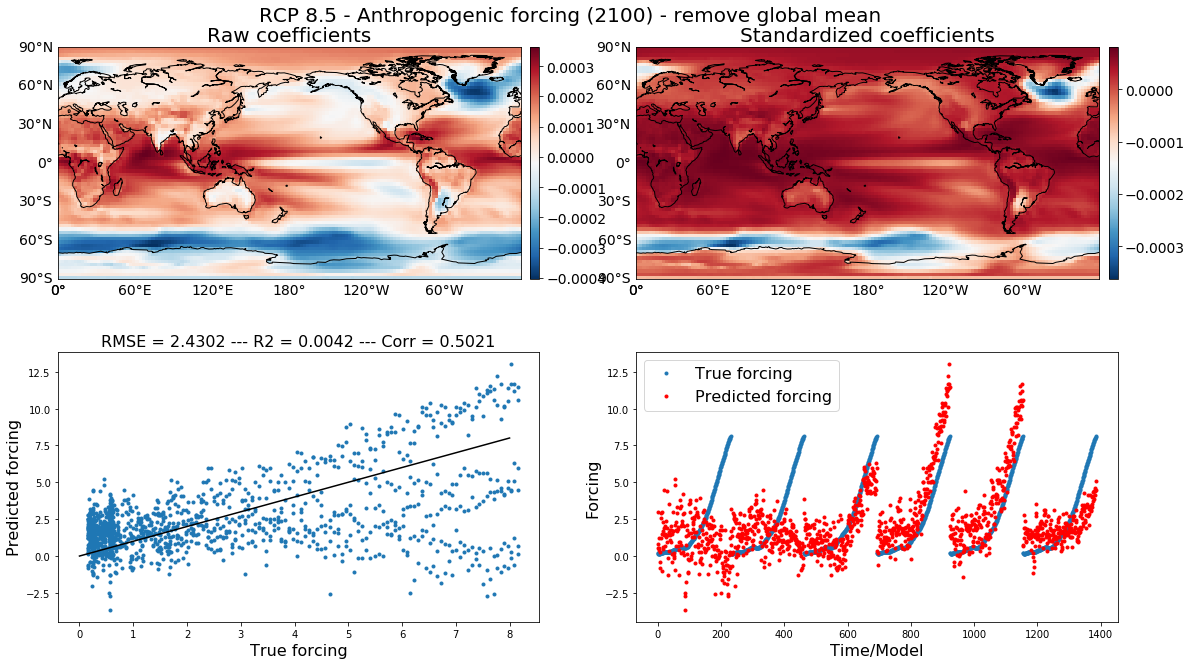

In [89]:
X = X_train_std
y = y_train.values
Xt = X_test_std
y_test_true = y_test.values

# Preprocessing : A in R^(q,p)
q = 1
p = X_train.shape[1]
A = np.zeros((q, p))
A[0,:] = np.ones((1, p))
A_mat = np.mat( A )

weightedRegr = False

if weightedRegr == True :
    PA = np.transpose(W) * np.transpose(A_mat) * np.linalg.inv( A_mat * W * np.transpose(A_mat) ) * A_mat
else: PA = np.transpose(A_mat) * np.linalg.inv( A_mat * np.transpose(A_mat) ) * A_mat

fig, axes = plt.subplots(2, 2, figsize = (19, 2*5))
suptitle = "RCP 8.5 - Anthropogenic forcing (" + str( endDate ) + ") - remove global mean"
fig.suptitle(suptitle, fontsize = 20)
fig.subplots_adjust(top = 0.95)

X_PA = np.mat( X ) * ( np.mat(np.eye(p)) - PA )
Xt_PA = np.mat( Xt ) * ( np.mat(np.eye(p)) - PA )
#m = np.transpose(np.tile(np.mean(X, axis = 1), (p, 1))) 
#X_PA = X - m

# Create a scaler object
sc_X_PA = StandardScaler(with_mean=False, with_std=False)
sc_Xt_PA = StandardScaler(with_mean=False, with_std=False)

# Fit the scaler to the data and transform
X_PA_std = sc_X_PA.fit_transform(X_PA)
Xt_PA_std = sc_Xt_PA.fit_transform(Xt_PA)
    
X_std_PA = X_PA.std(axis=0)

regr = linear_model.Ridge(alpha = X_PA.shape[0] * 5000 / 2)
#regr = linear_model.LinearRegression()
regr.fit(X_PA_std, y)
    
coefStd = regr.coef_
title = "Standardized coefficients"
fig.sca(axes[0, 1])
plotBasemap_subplots(coefStd.reshape(grid), title_subplot = title)

coefRaw = np.transpose(coefStd) / np.array(X_std_PA).reshape(X.shape[1], 1)
title = "Raw coefficients"
fig.sca(axes[0, 0])
plotBasemap_subplots(coefRaw.reshape(grid), title_subplot = title)

y_test_pred = regr.predict(Xt_PA_std)

#y_test_true = (y_test_true - np.mean(y_test_true)) / np.std(y_test_true) * np.std(y_test.values) + np.mean(y_test.values)
y_test_pred = (y_test_pred - np.mean(y_test_pred)) / np.std(y_test_pred) * np.std(y_test.values) + np.mean(y_test.values)

rmse = np.sqrt(np.mean((y_test_true - y_test_pred)**2)) 
r2 = r2_score(y_test_true, y_test_pred)
corr = np.corrcoef( np.transpose(y_test_true), np.transpose(y_test_pred) )[0,1]

plt.subplot(223)
plt.plot(y_test_true, y_test_pred, '.')
plt.xlabel("True forcing", fontsize = 16)
plt.ylabel("Predicted forcing", fontsize = 16)
x = np.linspace(0, 8, 100)
if corr >= 0:
    plt.plot(x, x[::1], 'k', linestyle = 'solid')
else:
    plt.plot(x, x[::-1], 'k', linestyle = 'solid')
plt.title("RMSE = " + str(np.round(rmse, 4)) + " --- R2 = " + str(np.round(r2, 4)) + " --- Corr = " + \
          str(np.round(corr, 4)), fontsize = 16)

plt.subplot(224)
plt.plot(y_test_true, '.', label = "True forcing")
plt.plot(y_test_pred, 'r.', label = "Predicted forcing")
plt.xlabel("Time/Model", fontsize = 16)
plt.ylabel("Forcing", fontsize = 16)
plt.legend(fontsize = 16);  
    
#fig.savefig("coefAll.png", bbox_inches = "tight")

In [84]:
X_PA_std.shape

(7161, 10368)

In [86]:
y.shape

(6237, 1)

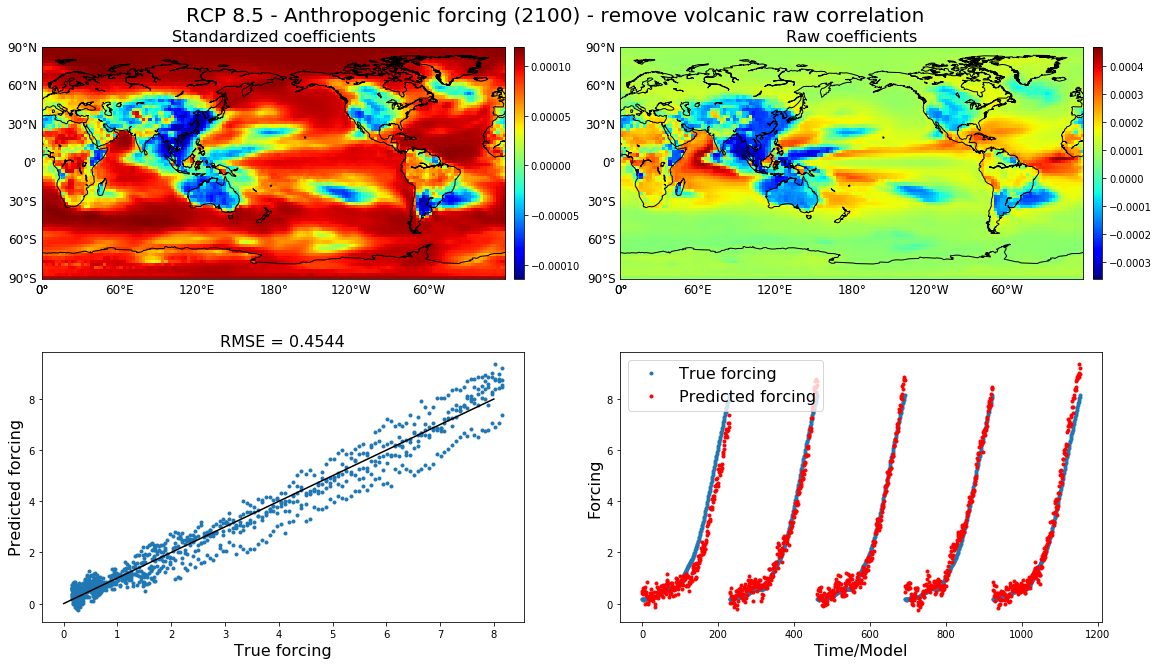

In [30]:
# Preprocessing : A in R^(q,p)
q = 1
A = np.zeros((q, p))
A[0,:] = corr_volcanic.reshape(1,-1)
A_mat = np.mat( A )
if weightedRegr == True :
    PA = np.transpose(W) * np.transpose(A_mat) * np.linalg.inv( A_mat * W * np.transpose(A_mat) ) * A_mat
else: PA = np.transpose(A_mat) * np.linalg.inv( A_mat * np.transpose(A_mat) ) * A_mat

fig, axes = plt.subplots(2, 2, figsize = (19, 10))
suptitle = "RCP 8.5 - Anthropogenic forcing (" + str( endDate ) + ") - remove volcanic raw correlation"
fig.suptitle(suptitle, fontsize = 20)
fig.subplots_adjust(top = 0.95)

X_PA = np.mat( X ) * ( np.mat(np.eye(p)) - PA )
# y_PA = ( np.mat(np.identity(N)) - PA ) * np.mat( y ) 
    
# Create a scaler object
sc_X_PA = StandardScaler(with_mean=True, with_std=True)
#sc_y_PA = StandardScaler(with_mean=True, with_std=True)

# Fit the scaler to the data and transform
X_PA_std = sc_X.fit_transform(X_PA)
#y_PA_std = sc_y.fit_transform(y_PA)
    
X_std_PA = X_PA.std(axis=0)

regr = linear_model.Ridge(alpha = selLambda)
regr.fit(X_PA_std, y)
    
coefStd = regr.coef_
title = "Standardized coefficients"
fig.sca(axes[0,0])
plotBasemap_subplots(coefStd.reshape(funcResolution(grid)), title, None)

coefRaw = np.transpose(coefStd) / np.array(X_std_PA).reshape(X.shape[1], 1)
title = "Raw coefficients"
fig.sca(axes[0,1])
plotBasemap_subplots(coefRaw.reshape(funcResolution(grid)), title, None)

y_test_pred = regr.predict(Xt)

y_test_true = (y_test_true - np.mean(y_test_true)) / np.std(y_test_true) * np.std(y_test.values) + np.mean(y_test.values)
y_test_pred = (y_test_pred - np.mean(y_test_pred)) / np.std(y_test_pred) * np.std(y_test.values) + np.mean(y_test.values)
    
plt.subplot(223)
plt.plot(y_test_true, y_test_pred, '.')
plt.xlabel("True forcing", fontsize = 16)
plt.ylabel("Predicted forcing", fontsize = 16)
x = np.linspace(0, 8, 100)
plt.plot(x, x, 'k', linestyle='solid')
rmse = np.sqrt(np.mean((y_test_true - y_test_pred)**2)) 
plt.title("RMSE = " + str(np.round(rmse, 4)), fontsize = 16)

plt.subplot(224)
plt.plot(y_test_true, '.', label = "True forcing")
plt.plot(y_test_pred, 'r.', label = "Predicted forcing")
plt.xlabel("Time/Model", fontsize = 16)
plt.ylabel("Forcing", fontsize = 16)
plt.legend(fontsize = 16);

    
#fig.savefig("coefAll.png", bbox_inches = "tight")

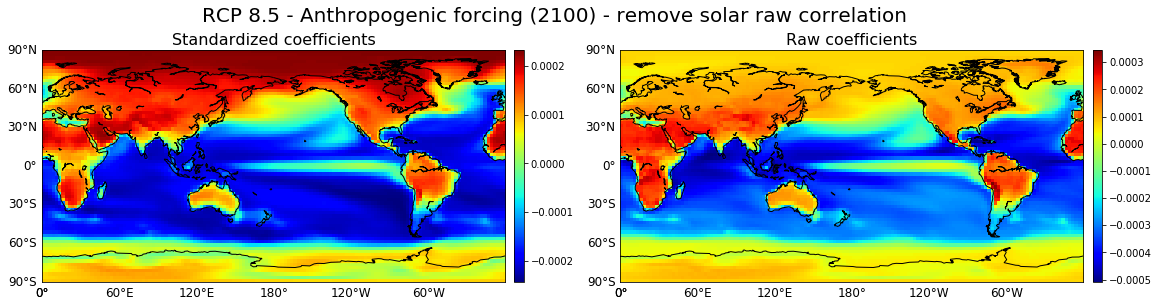

In [35]:
# Preprocessing : A in R^(q,p)
q = 1
A = np.zeros((q, p))
A[0,:] = corr_solar.reshape(1,-1)
A_mat = np.mat( A )
if weightedRegr == True :
    PA = np.transpose(W) * np.transpose(A_mat) * np.linalg.inv( A_mat * W * np.transpose(A_mat) ) * A_mat
else: PA = np.transpose(A_mat) * np.linalg.inv( A_mat * np.transpose(A_mat) ) * A_mat

fig, axes = plt.subplots(1, 2, figsize = (19, 5))
suptitle = "RCP 8.5 - Anthropogenic forcing (" + str( endDate ) + ") - remove solar raw correlation"
fig.suptitle(suptitle, fontsize = 20)
fig.subplots_adjust(top = 0.95)

X_PA = np.mat( X ) * ( np.mat(np.eye(p)) - PA )
# y_PA = ( np.mat(np.identity(N)) - PA ) * np.mat( y ) 
    
# Create a scaler object
sc_X_PA = StandardScaler(with_mean=True, with_std=True)
#sc_y_PA = StandardScaler(with_mean=True, with_std=True)

# Fit the scaler to the data and transform
X_PA_std = sc_X.fit_transform(X_PA)
#y_PA_std = sc_y.fit_transform(y_PA)
    
X_std_PA = X_PA.std(axis=0)

regr = linear_model.Ridge(alpha = selLambda)
regr.fit(X_PA_std, y)
    
coefStd = regr.coef_
title = "Standardized coefficients"
fig.sca(axes[0])
plotBasemap_subplots(coefStd.reshape(funcResolution(grid)), title, None)

coefRaw = np.transpose(coefStd) / np.array(X_std_PA).reshape(X.shape[1], 1)
title = "Raw coefficients"
fig.sca(axes[1])
plotBasemap_subplots(coefRaw.reshape(funcResolution(grid)), title, None)
    
#fig.savefig("coefAll.png", bbox_inches = "tight")

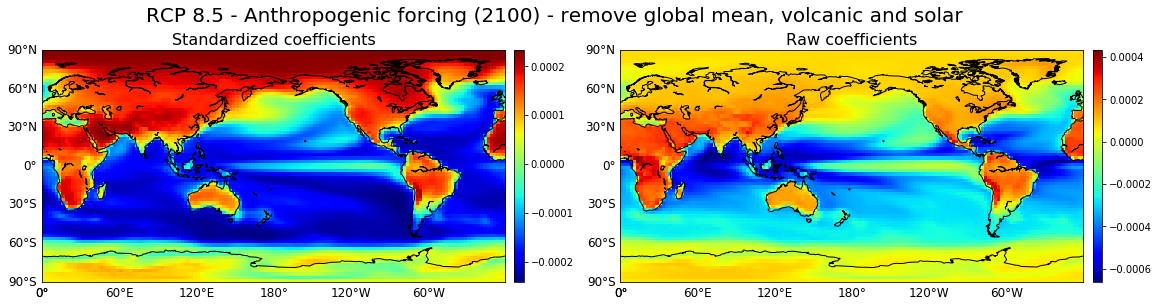

In [36]:
# Preprocessing : A in R^(q,p)
q = 3
A = np.zeros((q, p))
A[0,:] = np.ones((1, p))
A[1,:] = corr_volcanic.reshape(1,-1)
A[2,:] = corr_solar.reshape(1,-1)
A_mat = np.mat( A )
if weightedRegr == True :
    PA = np.transpose(W) * np.transpose(A_mat) * np.linalg.inv( A_mat * W * np.transpose(A_mat) ) * A_mat
else: 
    PA = np.transpose(A_mat) * np.linalg.inv( A_mat * np.transpose(A_mat) ) * A_mat

fig, axes = plt.subplots(1, 2, figsize = (19, 5))
suptitle = "RCP 8.5 - Anthropogenic forcing (" + str( endDate ) + ") - remove global mean, volcanic and solar"
fig.suptitle(suptitle, fontsize = 20)
fig.subplots_adjust(top = 0.95)

X_PA = np.mat( X ) * ( np.mat(np.eye(p)) - PA )
# y_PA = ( np.mat(np.identity(N)) - PA ) * np.mat( y ) 
    
# Create a scaler object
sc_X_PA = StandardScaler(with_mean=True, with_std=True)
#sc_y_PA = StandardScaler(with_mean=True, with_std=True)

# Fit the scaler to the data and transform
X_PA_std = sc_X.fit_transform(X_PA)
#y_PA_std = sc_y.fit_transform(y_PA)
    
X_std_PA = X_PA.std(axis=0)

regr = linear_model.Ridge(alpha = selLambda)
regr.fit(X_PA_std, y)
    
coefStd = regr.coef_
title = "Standardized coefficients"
fig.sca(axes[0])
plotBasemap_subplots(coefStd.reshape(funcResolution(grid)), title, None)

coefRaw = np.transpose(coefStd) / np.array(X_std_PA).reshape(X.shape[1], 1)
title = "Raw coefficients"
fig.sca(axes[1])
plotBasemap_subplots(coefRaw.reshape(funcResolution(grid)), title, None)
    
#fig.savefig("coefAll.png", bbox_inches = "tight")